In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, f1_score

In [264]:
user = pd.read_csv('takehome_users.csv', encoding_errors='ignore')
user

object_id        creation_time               name  \
0              1  2014-04-22 03:53:30     Clausen August   
1              2  2013-11-15 03:45:04      Poole Matthew   
2              3  2013-03-19 23:14:52  Bottrill Mitchell   
3              4  2013-05-21 08:09:28    Clausen Nicklas   
4              5  2013-01-17 10:14:20          Raw Grace   
...          ...                  ...                ...   
11995      11996  2013-09-06 06:14:15       Meier Sophia   
11996      11997  2013-01-10 18:28:37      Fisher Amelie   
11997      11998  2014-04-27 12:45:16        Haynes Jake   
11998      11999  2012-05-31 11:55:59       Faber Annett   
11999      12000  2014-01-26 08:57:12          Lima Thas   

                            email     creation_source  \
0        AugustCClausen@yahoo.com        GUEST_INVITE   
1          MatthewPoole@gustr.com          ORG_INVITE   
2      MitchellBottrill@gustr.com          ORG_INVITE   
3       NicklasSClausen@yahoo.com        GUEST_INVITE   
4              GraceRaw@yahoo.com        GUEST_INVITE   
...                           ...                 ...   
11995       SophiaMeier@gustr.com          ORG_INVITE   
11996      AmelieFisher@gmail.com  SIGNUP_GOOGLE_AUTH   
11997         JakeHaynes@cuvox.de        GUEST_INVITE   
11998          mhaerzxp@iuxiw.com   PERSONAL_PROJECTS   
11999   ThaisMeloLima@hotmail.com              SIGNUP   

       last_session_creation_time  opted_in_to_mailing_list  \
0                    1.398139e+09                         1   
1                    1.396238e+09                         0   
2                    1.363735e+09                         0   
3                    1.369210e+09                         0   
4                    1.358850e+09                         0   
...                           ...                       ...   
11995                1.378448e+09                         0   
11996                1.358275e+09                         0   
11997                1.398603e+09                         1   
11998                1.338638e+09                         0   
11999                1.390727e+09                         0   

       enabled_for_marketing_drip  org_id  invited_by_user_id  
0                               0      11             10803.0  
1                               0       1               316.0  
2                               0      94              1525.0  
3                               0       1              5151.0  
4                               0     193              5240.0  
...                           ...     ...                 ...  
11995                           0      89              8263.0  
11996                           0     200                 NaN  
11997                           1      83              8074.0  
11998                           0       6                 NaN  
11999                           1       0                 NaN  

[12000 rows x 10 columns]

In [265]:
user.creation_time = pd.to_datetime(user.creation_time)
user.last_session_creation_time = pd.to_datetime(user.last_session_creation_time, unit='s')

In [266]:
user.head()

object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4          GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  
0             10803.0  
1               316.0  
2              1525.0  
3              5151.0  
4              5240.0

In [267]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


Some nulls on last_session_creation_time and invited_by_user_id.

In [268]:
user['length'] = (user.last_session_creation_time-user.creation_time).dt.days
user.length = user.length.fillna(0)

In [269]:
user.describe().T

count         mean          std  min      25%  \
object_id                   12000.0  6000.500000  3464.245950  1.0  3000.75   
opted_in_to_mailing_list    12000.0     0.249500     0.432742  0.0     0.00   
enabled_for_marketing_drip  12000.0     0.149333     0.356432  0.0     0.00   
org_id                      12000.0   141.884583   124.056723  0.0    29.00   
invited_by_user_id           6417.0  5962.957145  3383.761968  3.0  3058.00   
length                      12000.0    43.543083   126.352426  0.0     0.00   

                               50%      75%      max  
object_id                   6000.5  9000.25  12000.0  
opted_in_to_mailing_list       0.0     0.00      1.0  
enabled_for_marketing_drip     0.0     0.00      1.0  
org_id                       108.0   238.25    416.0  
invited_by_user_id          5954.0  8817.00  11999.0  
length                         0.0     3.00    729.0

In [270]:
user.describe(include='object').T

count unique                  top  freq
name             12000  11349    Cavalcanti Victor     5
email            12000  11980  AlfieLane@yahoo.com     2
creation_source  12000      5           ORG_INVITE  4254

There is a lot of duplicated names and some duplicated emails.

In [271]:
user.duplicated(['name', 'email']).any()

True

In [272]:
user.duplicated().any()

False

There are both name and email duplicates but no complete duplicated rows.

In [273]:
engage = pd.read_csv('takehome_user_engagement.csv')
engage

time_stamp  user_id  visited
0       2014-04-22 03:53:30        1        1
1       2013-11-15 03:45:04        2        1
2       2013-11-29 03:45:04        2        1
3       2013-12-09 03:45:04        2        1
4       2013-12-25 03:45:04        2        1
...                     ...      ...      ...
207912  2013-09-06 06:14:15    11996        1
207913  2013-01-15 18:28:37    11997        1
207914  2014-04-27 12:45:16    11998        1
207915  2012-06-02 11:55:59    11999        1
207916  2014-01-26 08:57:12    12000        1

[207917 rows x 3 columns]

In [274]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


No nulls.

In [275]:
engage.describe().T

count         mean          std  min     25%     50%     75%  \
user_id  207917.0  5913.314197  3394.941674  1.0  3087.0  5682.0  8944.0   
visited  207917.0     1.000000     0.000000  1.0     1.0     1.0     1.0   

             max  
user_id  12000.0  
visited      1.0

In [276]:
engage.describe(include='object').T

count  unique                  top freq
time_stamp  207917  207220  2013-04-06 21:21:37    2

In [277]:
engage.time_stamp = pd.to_datetime(engage.time_stamp, format='%y-%m-%d', exact=False)
engage = engage.set_index('time_stamp')

In [278]:
(engage.groupby('user_id').rolling('1D').sum()>1).any()

visited    False
dtype: bool

No daily multiple visit.

In [279]:
# total number of visit of each user
total_visit = engage.groupby('user_id', as_index=False).sum()

In [280]:
user = user.merge(total_visit, how='left', left_on='object_id', right_on='user_id').fillna({'visited':0})

In [281]:
adopted = engage.groupby('user_id', as_index=False).rolling('7D').sum().query('visited>=3').user_id.unique()

adopted user = users who have more than 3 visits in 7 days period

In [282]:
len(adopted)/user.shape[0]*100

13.350000000000001

In [283]:
user['adopted'] = [1 if i in adopted else 0 for i in user.object_id]

adopted=1 , otherwise=0

In [284]:
user.head()

object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4          GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  length  user_id  visited  adopted  
0             10803.0     0.0      1.0      1.0        0  
1               316.0   136.0      2.0     14.0        1  
2              1525.0     0.0      3.0      1.0        0  
3              5151.0     1.0      4.0      1.0        0  
4              5240.0     5.0      5.0      1.0        0

In [285]:
df = user.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'user_id'], axis=1)

In [286]:
df[['org_id', 'invited_by_user_id']] = df[['org_id', 'invited_by_user_id']].astype('object')

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  object 
 4   invited_by_user_id          6417 non-null   object 
 5   length                      12000 non-null  float64
 6   visited                     12000 non-null  float64
 7   adopted                     12000 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 843.8+ KB


In [288]:
df.describe()

opted_in_to_mailing_list  enabled_for_marketing_drip        length  \
count              12000.000000                12000.000000  12000.000000   
mean                   0.249500                    0.149333     43.543083   
std                    0.432742                    0.356432    126.352426   
min                    0.000000                    0.000000      0.000000   
25%                    0.000000                    0.000000      0.000000   
50%                    0.000000                    0.000000      0.000000   
75%                    0.000000                    0.000000      3.000000   
max                    1.000000                    1.000000    729.000000   

            visited       adopted  
count  12000.000000  12000.000000  
mean      17.326417      0.133500  
std       64.287839      0.340128  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      0.000000  
max      606.000000      1.000000

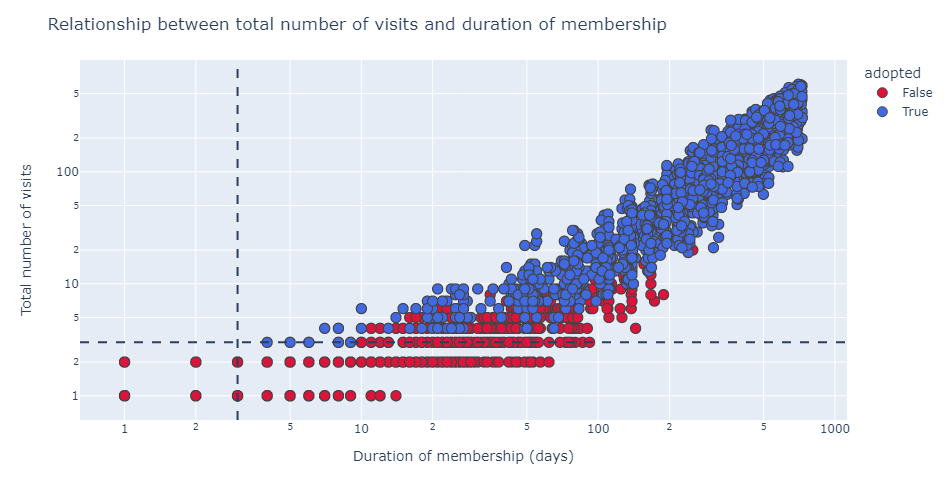

In [208]:
custom_colors = {1: "royalblue", 0: "crimson"}
fig = px.scatter(df, x='length', y='visited', color=df.adopted.astype('boolean'), log_y=True, log_x=True,
                 color_discrete_map=custom_colors, labels={'color':'adopted'})
fig.update_traces(marker={'size':10, 'line':{'width':1}})
fig.add_vline(x=3, line={'dash':'dash'})
fig.add_hline(y=3, line={'dash':'dash'})
fig.update_xaxes(title='Duration of membership (days)')
fig.update_yaxes(title='Total number of visits')
fig.update_layout(template='plotly', width=950, height=500, title='Relationship between total number of visits and duration of membership')
fig.show('png')

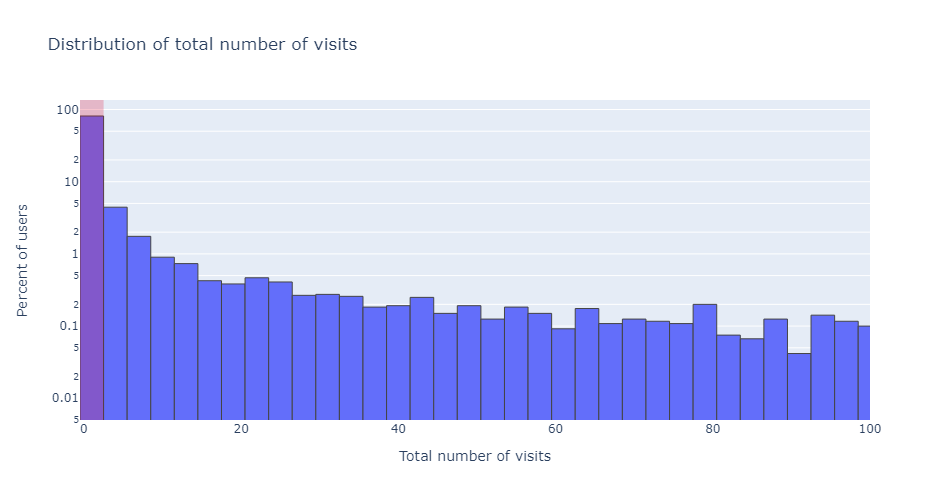

In [206]:
fig = go.Figure()
trace = go.Histogram(x=df.visited, xbins=dict(size=3), histnorm='percent', autobinx=False)
fig.add_trace(trace)
fig.update_traces(marker={'line':{'width':1}})
fig.update_xaxes(title='Total number of visits')
fig.update_yaxes(title='Percent of users')
fig.add_vrect(x0=-0.5, x1=2.5, 
              annotation_text="", annotation_position="top",
              fillcolor="crimson", opacity=0.25, line_width=0)
fig.update_layout(xaxis_range=[-0.5, 100], yaxis_type="log", title='Distribution of total number of visits', 
                  width=950, height=500, barmode='overlay', showlegend=False)
fig.show('png')

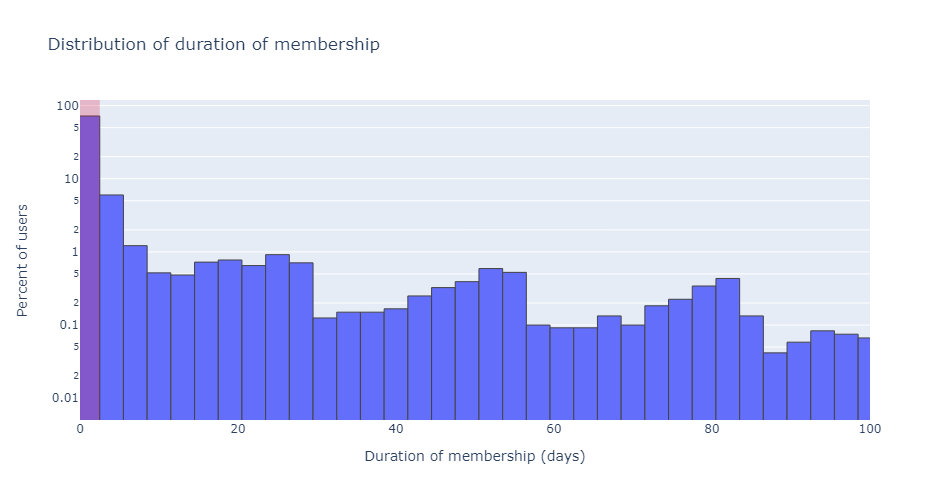

In [204]:
fig = go.Figure()
trace = go.Histogram(x=df.length, xbins=dict(size=3), histnorm='percent', autobinx=False)
fig.add_trace(trace)
fig.update_traces(marker={'line':{'width':1}})
fig.update_xaxes(title='Duration of membership (days)')
fig.update_yaxes(title='Percent of users')
fig.add_vrect(x0=-0.5, x1=2.5, 
              annotation_text="", annotation_position="top",
              fillcolor="crimson", opacity=0.25, line_width=0)
fig.update_layout(xaxis_range=[0, 100], yaxis_type="log", title='Distribution of duration of membership', 
                  width=950, height=500, showlegend=False)
fig.show('png')

In [289]:
df = df.loc[(df.visited>=3) & (df.length>=3)]

In [198]:
len(adopted)/df.shape[0]

0.7126334519572953

In [144]:
df['freq'] = df.visited/df.length

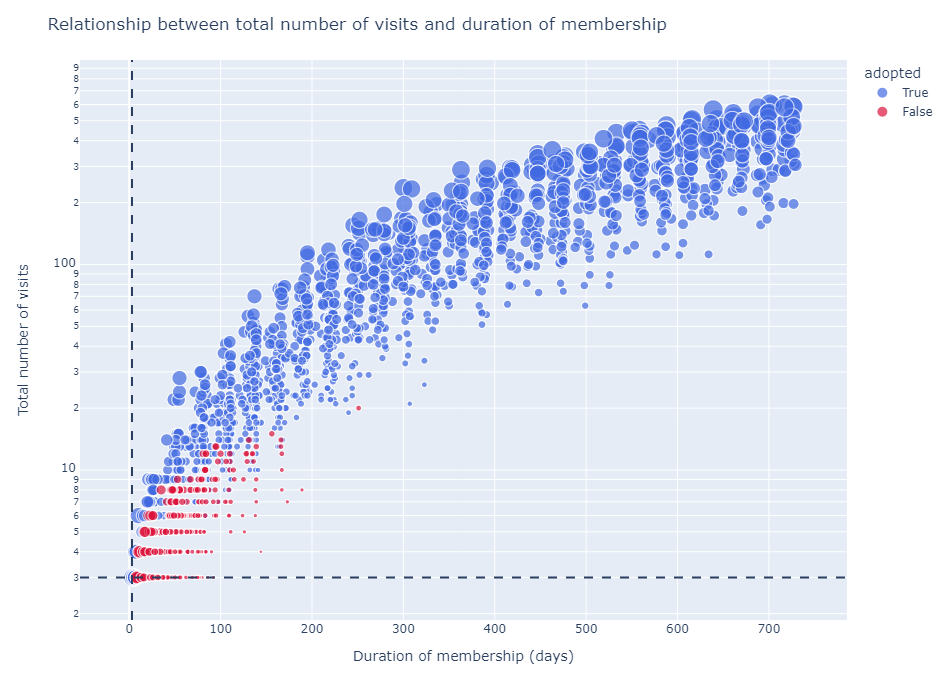

In [32]:
custom_colors = {1: "royalblue", 0: "crimson"}
fig = px.scatter(df, x='length', y='visited', color=df.adopted.astype('boolean'), size='freq',log_y=True, 
                 color_discrete_map=custom_colors, labels={'color':'adopted'})
fig.update_traces(marker={'line':{'width':1}})
fig.add_vline(x=3, line={'dash':'dash'})
fig.add_hline(y=3, line={'dash':'dash'})
fig.update_xaxes(title='Duration of membership (days)')
fig.update_yaxes(title='Total number of visits')
fig.update_layout(template='plotly', width=950, height=700, title='Relationship between total number of visits and duration of membership')
fig.show('png')

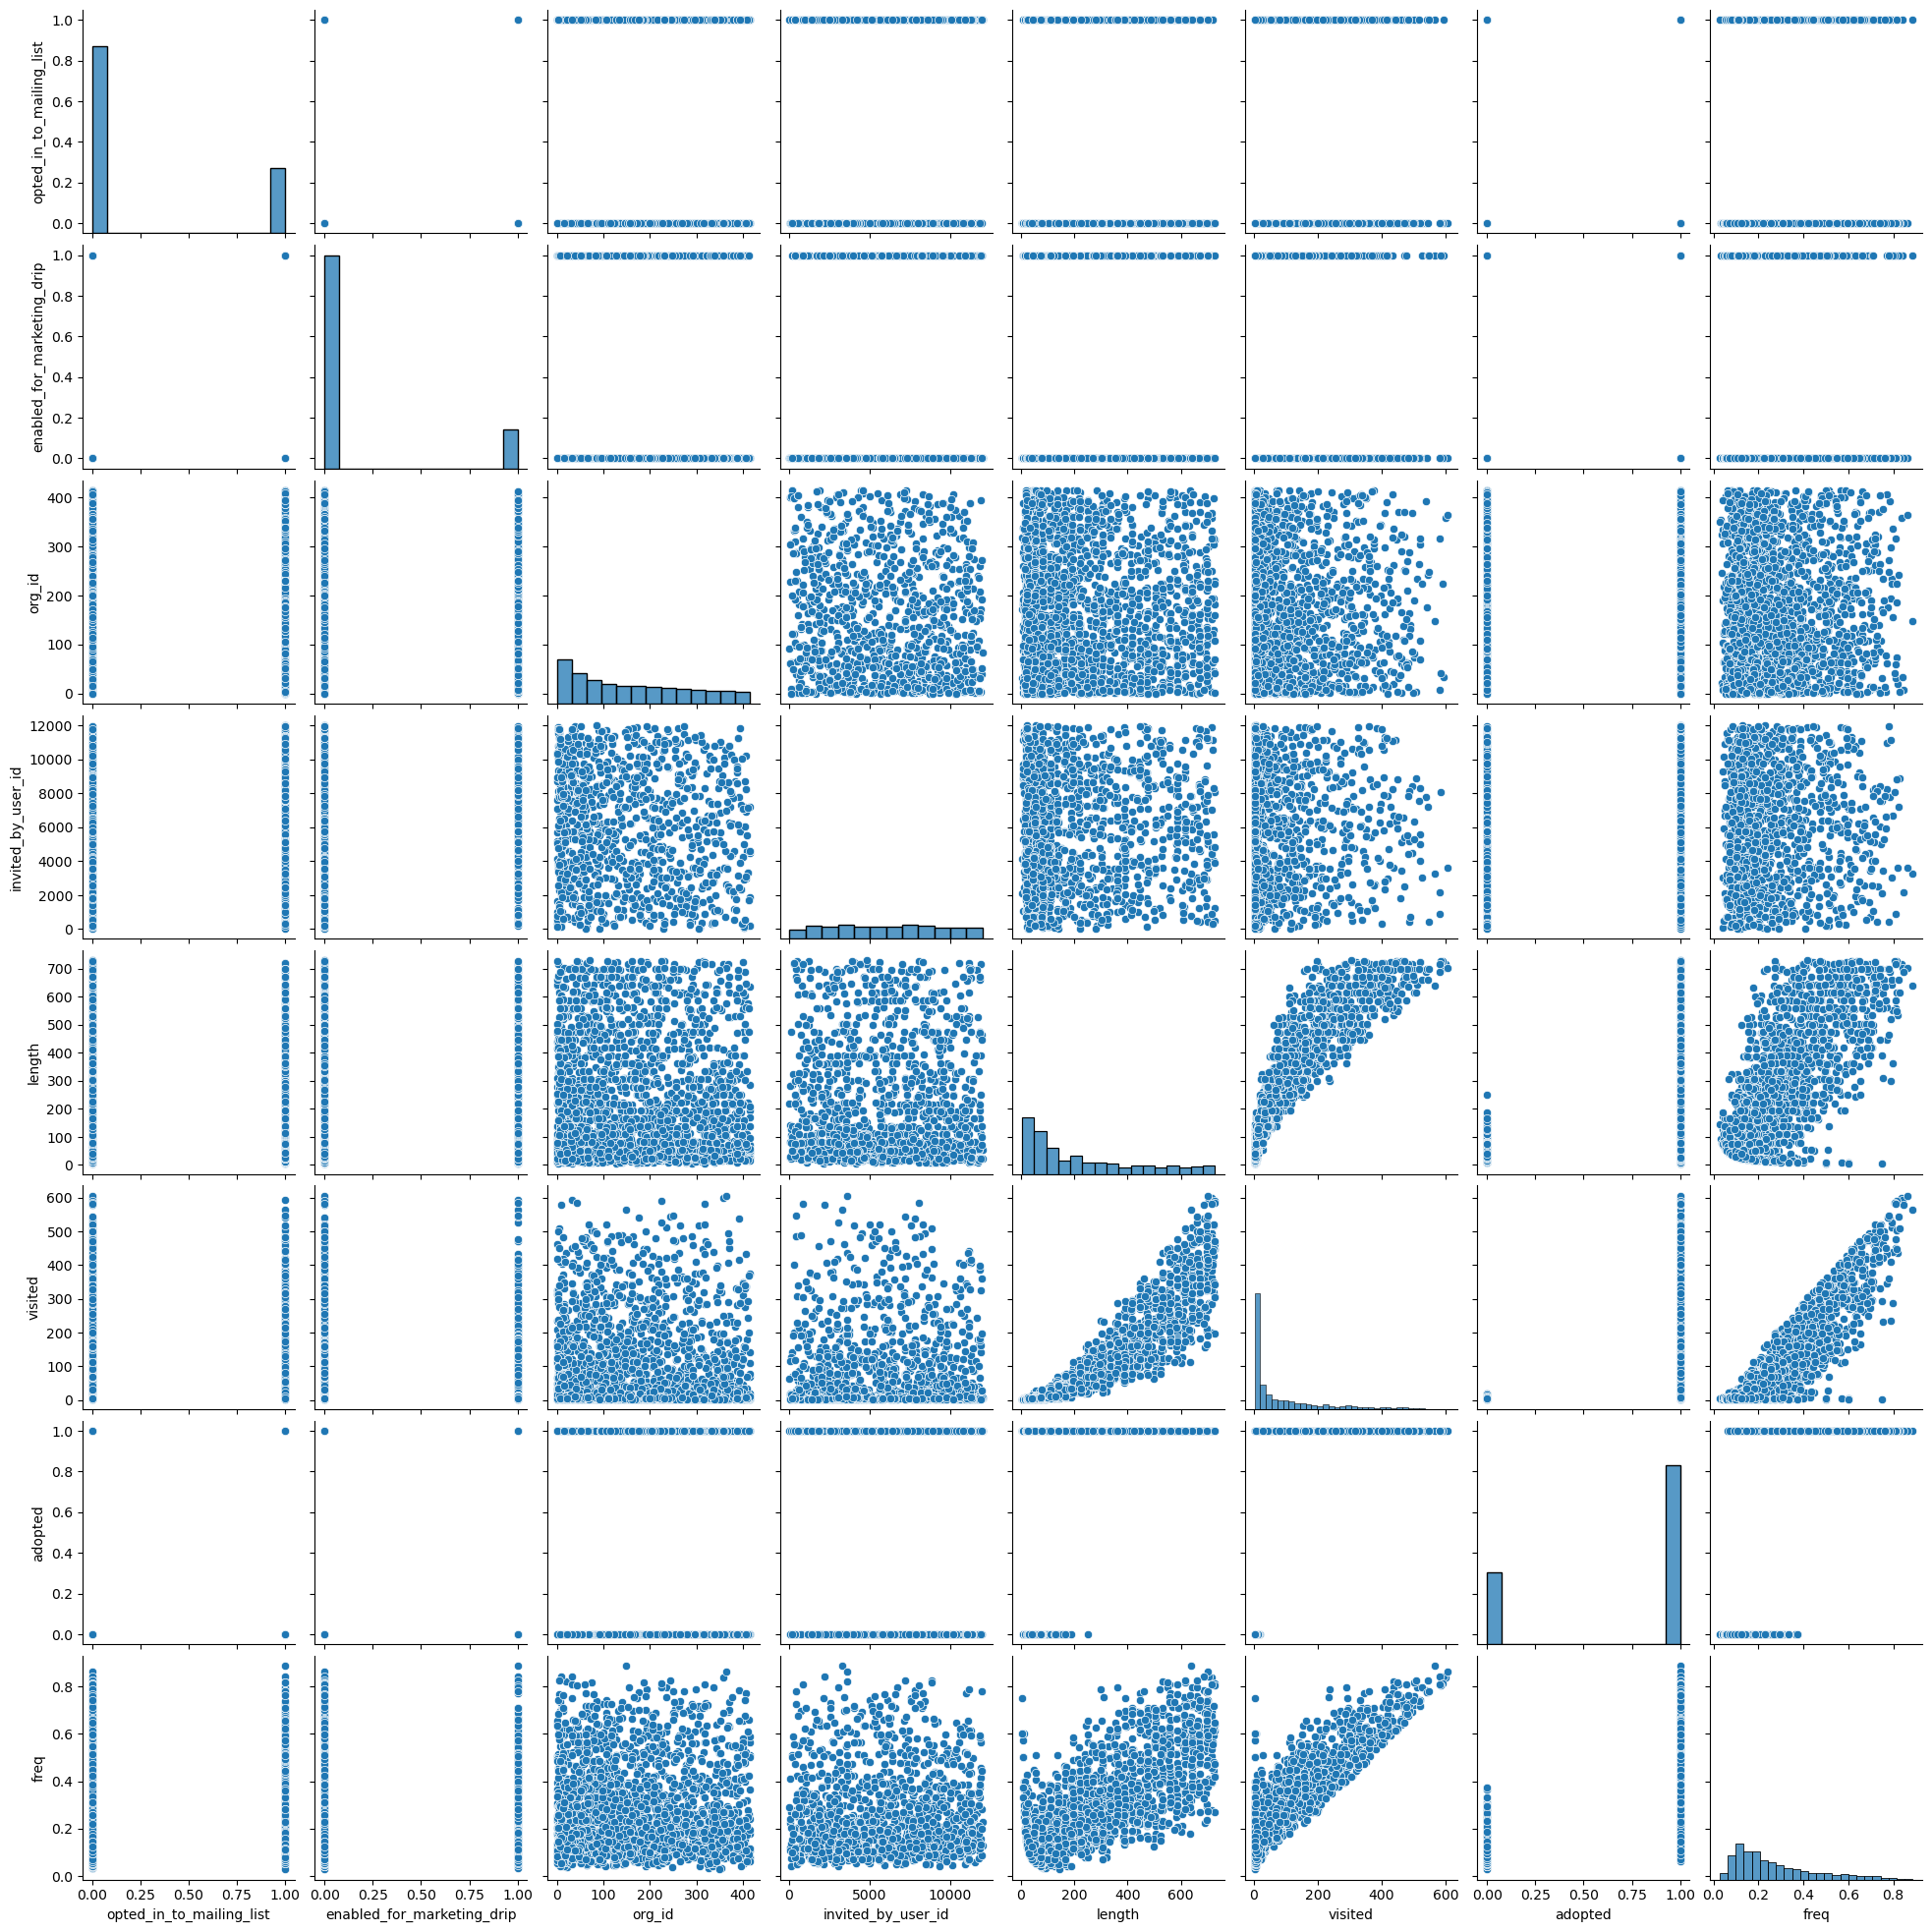

In [33]:
sns.pairplot(df)
plt.show()

In [34]:
corr = df.select_dtypes(include='number').corr('kendall')
corr

opted_in_to_mailing_list  \
opted_in_to_mailing_list                    1.000000   
enabled_for_marketing_drip                  0.488276   
length                                     -0.001076   
visited                                     0.008818   
adopted                                     0.004719   
freq                                        0.033505   

                            enabled_for_marketing_drip    length   visited  \
opted_in_to_mailing_list                      0.488276 -0.001076  0.008818   
enabled_for_marketing_drip                    1.000000  0.005561  0.003836   
length                                        0.005561  1.000000  0.829691   
visited                                       0.003836  0.829691  1.000000   
adopted                                      -0.005425  0.548773  0.614215   
freq                                         -0.002921  0.438522  0.628234   

                             adopted      freq  
opted_in_to_mailing_list    0.004719  0.033505  
enabled_for_marketing_drip -0.005425 -0.002921  
length                      0.548773  0.438522  
visited                     0.614215  0.628234  
adopted                     1.000000  0.478355  
freq                        0.478355  1.000000

In [35]:
fig = px.imshow(corr)
fig.show()

In [36]:
fig = px.scatter(x=df.visited/df.length, y=df.adopted)
fig.show()

In [37]:
fig = px.scatter(df, x='visited', y='adopted')
fig.show()

In [38]:
source = df.groupby('creation_source', as_index=False).agg(avg = ('adopted','mean'), sd = ('adopted','std'))
fig = px.bar(source, x='creation_source', y='avg')
fig.show()

In [39]:
org = df.groupby('org_id', as_index=False).agg(avg = ('adopted','mean'), sd = ('adopted','std'))
fig = px.scatter(org, x='org_id', y='avg')
fig.show()

In [40]:
invite = df.groupby('invited_by_user_id', as_index=False).agg(avg = ('adopted','mean'), sd = ('adopted','std'))
fig = px.scatter(invite, x='invited_by_user_id', y='avg')
fig.show()

In [145]:
X = df.drop('adopted', axis=1)
y = df.adopted

In [42]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ("oh", OneHotEncoder(drop='first', handle_unknown="ignore"), ['creation_source']),
        ("target", TargetEncoder(random_state=0), ['org_id', 'invited_by_user_id'])],
    remainder = 'passthrough')

In [44]:
def xgb_eval(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    
    xgb_param_grid = {'objective':'binary:logistic', 'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'gamma':gamma, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight}
    steps = [('prep', preprocessor), ('xgb', xgb.XGBClassifier(**xgb_param_grid))]
    pipeline =  Pipeline(steps)
    
    score = cross_val_score(pipeline, X, y, scoring='f1', cv=kf)
    return score.mean()

In [45]:
sampler = optuna.samplers.TPESampler(seed=0)
xgb_study = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study.optimize(xgb_eval, n_trials=1000)

[I 2024-03-07 18:32:59,170] A new study created in memory with name: no-name-f4cc8d04-d778-4b47-8a47-8f484604c49a
[I 2024-03-07 18:33:00,502] Trial 0 finished with value: 0.9428819220362996 and parameters: {'n_estimators': 320, 'max_depth': 15, 'learning_rate': 0.6027673484378832, 'gamma': 0.5448831829968969, 'reg_alpha': 0.4236547993389047, 'reg_lambda': 0.6458941130666561, 'subsample': 0.4432113391500656, 'colsample_bytree': 0.892855270774259, 'min_child_weight': 9.64026132896019}. Best is trial 0 with value: 0.9428819220362996.
[I 2024-03-07 18:33:01,324] Trial 1 finished with value: 0.9379410757045278 and parameters: {'n_estimators': 253, 'max_depth': 17, 'learning_rate': 0.5288996308037069, 'gamma': 0.5680445610939323, 'reg_alpha': 0.925596638292661, 'reg_lambda': 0.07103605819788694, 'subsample': 0.09625800670452529, 'colsample_bytree': 0.03001621346592246, 'min_child_weight': 8.342936470924586}. Best is trial 0 with value: 0.9428819220362996.
[I 2024-03-07 18:33:02,594] Trial 2 

[I 2024-03-07 18:33:31,350] Trial 19 finished with value: 0.937100477230626 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.827097450269297, 'gamma': 0.930054749667052, 'reg_alpha': 0.8689279280803875, 'reg_lambda': 0.3381121448805884, 'subsample': 0.32652919201272945, 'colsample_bytree': 0.49987978832437224, 'min_child_weight': 2.179731275272538}. Best is trial 12 with value: 0.955771880133909.
[I 2024-03-07 18:33:32,818] Trial 20 finished with value: 0.9447253878735898 and parameters: {'n_estimators': 380, 'max_depth': 11, 'learning_rate': 0.38226614606579074, 'gamma': 0.16652095582881066, 'reg_alpha': 0.6985753159920315, 'reg_lambda': 0.6373142789399874, 'subsample': 0.6404572288619159, 'colsample_bytree': 0.21436472051614192, 'min_child_weight': 3.7540739869610795}. Best is trial 12 with value: 0.955771880133909.
[I 2024-03-07 18:33:35,751] Trial 21 finished with value: 0.9517273696056769 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate'

[I 2024-03-07 18:34:05,458] Trial 39 finished with value: 0.9524623383349319 and parameters: {'n_estimators': 140, 'max_depth': 14, 'learning_rate': 0.0722375027435312, 'gamma': 0.3018211373988891, 'reg_alpha': 0.7508662333710141, 'reg_lambda': 0.7389323727433617, 'subsample': 0.5507464417338197, 'colsample_bytree': 0.2065209247426983, 'min_child_weight': 4.716731317593576}. Best is trial 12 with value: 0.955771880133909.
[I 2024-03-07 18:34:06,201] Trial 40 finished with value: 0.9508747361846532 and parameters: {'n_estimators': 138, 'max_depth': 14, 'learning_rate': 0.3391233881621967, 'gamma': 0.7256358438708677, 'reg_alpha': 0.7583157040573469, 'reg_lambda': 0.7539307071194423, 'subsample': 0.49620734978256953, 'colsample_bytree': 0.20089032079851118, 'min_child_weight': 6.812137230378881}. Best is trial 12 with value: 0.955771880133909.
[I 2024-03-07 18:34:06,937] Trial 41 finished with value: 0.9473753823595841 and parameters: {'n_estimators': 142, 'max_depth': 17, 'learning_rate

[I 2024-03-07 18:34:38,713] Trial 59 finished with value: 0.9532257840064045 and parameters: {'n_estimators': 265, 'max_depth': 20, 'learning_rate': 0.040483172761314204, 'gamma': 0.474750551986182, 'reg_alpha': 0.28796545351349356, 'reg_lambda': 0.904208490911436, 'subsample': 0.8561345405663201, 'colsample_bytree': 0.33955965564767077, 'min_child_weight': 1.9881696881251665}. Best is trial 12 with value: 0.955771880133909.
[I 2024-03-07 18:34:40,314] Trial 60 finished with value: 0.95302838537858 and parameters: {'n_estimators': 301, 'max_depth': 19, 'learning_rate': 0.10719064120612193, 'gamma': 0.4272343399099065, 'reg_alpha': 0.3478884795543634, 'reg_lambda': 0.9343347150450658, 'subsample': 0.8617771293127636, 'colsample_bytree': 0.32346492471360927, 'min_child_weight': 2.0362362526243074}. Best is trial 12 with value: 0.955771880133909.
[I 2024-03-07 18:34:41,958] Trial 61 finished with value: 0.9521161190157406 and parameters: {'n_estimators': 299, 'max_depth': 19, 'learning_ra

[I 2024-03-07 18:35:12,079] Trial 79 finished with value: 0.9525325770371985 and parameters: {'n_estimators': 312, 'max_depth': 11, 'learning_rate': 0.27764753721113744, 'gamma': 0.8800420108837833, 'reg_alpha': 0.35914253176380334, 'reg_lambda': 0.6848942726410969, 'subsample': 0.7024904665627474, 'colsample_bytree': 0.5390877545805794, 'min_child_weight': 0.9654581950350289}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:35:13,920] Trial 80 finished with value: 0.9517328213516304 and parameters: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.06039602432833547, 'gamma': 0.48465184246021925, 'reg_alpha': 0.3254467486234779, 'reg_lambda': 0.86825404950521, 'subsample': 0.6427733499692104, 'colsample_bytree': 0.37805892481958153, 'min_child_weight': 2.926213722443776}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:35:15,468] Trial 81 finished with value: 0.9526183920646976 and parameters: {'n_estimators': 269, 'max_depth': 10, 'learning_r

[I 2024-03-07 18:35:43,163] Trial 99 finished with value: 0.9449119817050299 and parameters: {'n_estimators': 233, 'max_depth': 10, 'learning_rate': 0.551376797121637, 'gamma': 0.7893996120988757, 'reg_alpha': 0.560510664315395, 'reg_lambda': 0.7422544319232576, 'subsample': 0.697959304765096, 'colsample_bytree': 0.25508980888627564, 'min_child_weight': 3.4905543773916548}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:35:44,391] Trial 100 finished with value: 0.9527903161078054 and parameters: {'n_estimators': 269, 'max_depth': 9, 'learning_rate': 0.04086172894768105, 'gamma': 0.3169883195795482, 'reg_alpha': 0.5233786312335127, 'reg_lambda': 0.559747171264076, 'subsample': 0.6596806641766061, 'colsample_bytree': 0.18263311924486106, 'min_child_weight': 4.994672398021475}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:35:45,848] Trial 101 finished with value: 0.952404220814379 and parameters: {'n_estimators': 305, 'max_depth': 10, 'learning_rate

[I 2024-03-07 18:36:19,176] Trial 119 finished with value: 0.9504806509851356 and parameters: {'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.06626873666493105, 'gamma': 0.22766575753840546, 'reg_alpha': 0.4521730929073442, 'reg_lambda': 0.5773037525278658, 'subsample': 0.7265562768308553, 'colsample_bytree': 0.29861702543956564, 'min_child_weight': 3.937834357031205}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:36:20,828] Trial 120 finished with value: 0.94938669915357 and parameters: {'n_estimators': 332, 'max_depth': 10, 'learning_rate': 0.35268400608124606, 'gamma': 0.3166340483602707, 'reg_alpha': 0.512785606033404, 'reg_lambda': 0.6974995048416259, 'subsample': 0.7905528855918033, 'colsample_bytree': 0.5787891725690186, 'min_child_weight': 3.3458748929941136}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:36:22,931] Trial 121 finished with value: 0.9539096532675149 and parameters: {'n_estimators': 357, 'max_depth': 12, 'learning_

[I 2024-03-07 18:36:57,021] Trial 139 finished with value: 0.9522144026604401 and parameters: {'n_estimators': 310, 'max_depth': 12, 'learning_rate': 0.046274914295678614, 'gamma': 0.2533339661316163, 'reg_alpha': 0.5111555172841776, 'reg_lambda': 0.3218115216237666, 'subsample': 0.6516432835358508, 'colsample_bytree': 0.18474874972123786, 'min_child_weight': 3.499424213601966}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:36:58,422] Trial 140 finished with value: 0.951415217956329 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.06019776776406456, 'gamma': 0.22718239217371552, 'reg_alpha': 0.4566995453135244, 'reg_lambda': 0.8153512525512984, 'subsample': 0.6761027725106583, 'colsample_bytree': 0.15550566280264316, 'min_child_weight': 3.30053829429706}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:37:00,115] Trial 141 finished with value: 0.9535788259364153 and parameters: {'n_estimators': 324, 'max_depth': 11, 'learni

[I 2024-03-07 18:37:32,022] Trial 159 finished with value: 0.9525932604862509 and parameters: {'n_estimators': 420, 'max_depth': 11, 'learning_rate': 0.0010891038654955443, 'gamma': 0.177318861860684, 'reg_alpha': 0.42416241377638375, 'reg_lambda': 0.5245382149507625, 'subsample': 0.7083029515343209, 'colsample_bytree': 0.4544650541814549, 'min_child_weight': 3.153317691520126}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:37:33,989] Trial 160 finished with value: 0.9494910528078397 and parameters: {'n_estimators': 393, 'max_depth': 9, 'learning_rate': 0.09496387111075749, 'gamma': 0.24307577784973122, 'reg_alpha': 0.7194176386156264, 'reg_lambda': 0.6993255266549944, 'subsample': 0.7740960022606043, 'colsample_bytree': 0.5887525464578669, 'min_child_weight': 3.788782763224098}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:37:35,681] Trial 161 finished with value: 0.9542217259571697 and parameters: {'n_estimators': 308, 'max_depth': 12, 'learni

[I 2024-03-07 18:38:06,356] Trial 179 finished with value: 0.9492276991596753 and parameters: {'n_estimators': 291, 'max_depth': 10, 'learning_rate': 0.08776044366498706, 'gamma': 0.051373366767793804, 'reg_alpha': 0.44288386250024814, 'reg_lambda': 0.8806465595685304, 'subsample': 0.9087913800000529, 'colsample_bytree': 0.30477653797341825, 'min_child_weight': 4.213201865603547}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:38:07,965] Trial 180 finished with value: 0.9545335247194439 and parameters: {'n_estimators': 325, 'max_depth': 9, 'learning_rate': 0.03959991234567216, 'gamma': 0.1422903554623013, 'reg_alpha': 0.41499988816739575, 'reg_lambda': 0.710884113242389, 'subsample': 0.7524755421244655, 'colsample_bytree': 0.2754415857927143, 'min_child_weight': 3.793114808572665}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:38:09,741] Trial 181 finished with value: 0.9542079042179884 and parameters: {'n_estimators': 316, 'max_depth': 9, 'learni

[I 2024-03-07 18:38:38,900] Trial 199 finished with value: 0.9539616384171445 and parameters: {'n_estimators': 334, 'max_depth': 8, 'learning_rate': 0.08405682076575707, 'gamma': 0.11705673327363511, 'reg_alpha': 0.4621758424868086, 'reg_lambda': 0.7877730223553413, 'subsample': 0.7817380955395419, 'colsample_bytree': 0.219592476237615, 'min_child_weight': 2.8798996744666967}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:38:40,227] Trial 200 finished with value: 0.9551401984402423 and parameters: {'n_estimators': 274, 'max_depth': 10, 'learning_rate': 0.048060498853958425, 'gamma': 0.19045228888377833, 'reg_alpha': 0.41705102623510526, 'reg_lambda': 0.8136592988697173, 'subsample': 0.8030011951077487, 'colsample_bytree': 0.20826324678569702, 'min_child_weight': 3.2592288495243165}. Best is trial 72 with value: 0.9560179737394744.
[I 2024-03-07 18:38:41,481] Trial 201 finished with value: 0.9531785098948079 and parameters: {'n_estimators': 245, 'max_depth': 9, 'lear

[I 2024-03-07 18:39:04,764] Trial 218 finished with value: 0.9529427684159509 and parameters: {'n_estimators': 294, 'max_depth': 9, 'learning_rate': 0.08845425684952264, 'gamma': 0.14755923938087834, 'reg_alpha': 0.3760401790504655, 'reg_lambda': 0.8099168494567072, 'subsample': 0.9375351495204387, 'colsample_bytree': 0.16555384864134443, 'min_child_weight': 2.802985885626526}. Best is trial 202 with value: 0.9560469200574344.
[I 2024-03-07 18:39:06,168] Trial 219 finished with value: 0.9523061462609013 and parameters: {'n_estimators': 274, 'max_depth': 10, 'learning_rate': 0.11166845499449284, 'gamma': 0.10852199415021513, 'reg_alpha': 0.40491673548006907, 'reg_lambda': 0.8835851438647647, 'subsample': 0.9007166334652148, 'colsample_bytree': 0.19155798506535326, 'min_child_weight': 2.428755163487649}. Best is trial 202 with value: 0.9560469200574344.
[I 2024-03-07 18:39:07,476] Trial 220 finished with value: 0.9514839841994549 and parameters: {'n_estimators': 265, 'max_depth': 10, 'le

[I 2024-03-07 18:39:35,277] Trial 238 finished with value: 0.9538596990022604 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.07421218478641514, 'gamma': 0.5663520512812767, 'reg_alpha': 0.46465471486281584, 'reg_lambda': 0.8457777503305086, 'subsample': 0.8592264541645447, 'colsample_bytree': 0.19272957544397026, 'min_child_weight': 2.341396775735667}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:39:37,468] Trial 239 finished with value: 0.9542989652332613 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.09551368895010086, 'gamma': 0.089019125028145, 'reg_alpha': 0.5107344751534858, 'reg_lambda': 0.8021655509515653, 'subsample': 0.833389133843163, 'colsample_bytree': 0.21783985732369163, 'min_child_weight': 2.7171702158050435}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:39:39,187] Trial 240 finished with value: 0.9538704047180595 and parameters: {'n_estimators': 306, 'max_depth': 9, 'learnin

[I 2024-03-07 18:40:13,374] Trial 258 finished with value: 0.9515248518155179 and parameters: {'n_estimators': 297, 'max_depth': 9, 'learning_rate': 0.05793576141654611, 'gamma': 0.12521252365673066, 'reg_alpha': 0.44234242764454434, 'reg_lambda': 0.5057393655063654, 'subsample': 0.7913110589910965, 'colsample_bytree': 0.14576315294368888, 'min_child_weight': 3.1895973171881495}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:40:15,156] Trial 259 finished with value: 0.9535584272225345 and parameters: {'n_estimators': 284, 'max_depth': 15, 'learning_rate': 0.0932646190724944, 'gamma': 0.09767775013481529, 'reg_alpha': 0.4710179865535211, 'reg_lambda': 0.4400858414238425, 'subsample': 0.8441612207176299, 'colsample_bytree': 0.22202318082474728, 'min_child_weight': 3.0063933969820478}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:40:16,719] Trial 260 finished with value: 0.9528314984767766 and parameters: {'n_estimators': 276, 'max_depth': 8, 'le

[I 2024-03-07 18:40:48,895] Trial 278 finished with value: 0.952928311133711 and parameters: {'n_estimators': 262, 'max_depth': 8, 'learning_rate': 0.08747885942194655, 'gamma': 0.5682235481852722, 'reg_alpha': 0.4275856916178361, 'reg_lambda': 0.4496984752678866, 'subsample': 0.8112274339414284, 'colsample_bytree': 0.8941541554164699, 'min_child_weight': 2.8706953755938662}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:40:50,301] Trial 279 finished with value: 0.9537933612012311 and parameters: {'n_estimators': 269, 'max_depth': 7, 'learning_rate': 0.1259230642490619, 'gamma': 0.582476944005939, 'reg_alpha': 0.4335555859010922, 'reg_lambda': 0.58278029081688, 'subsample': 0.776204585624829, 'colsample_bytree': 0.15776545679955586, 'min_child_weight': 3.2872601207127374}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:40:51,767] Trial 280 finished with value: 0.9544624872965439 and parameters: {'n_estimators': 260, 'max_depth': 8, 'learning_rat

[I 2024-03-07 18:41:24,163] Trial 298 finished with value: 0.9532223903725653 and parameters: {'n_estimators': 254, 'max_depth': 8, 'learning_rate': 0.10356415924185594, 'gamma': 0.0845293918187602, 'reg_alpha': 0.5154801370933991, 'reg_lambda': 0.8403944593812449, 'subsample': 0.8838456083265569, 'colsample_bytree': 0.23033071322696247, 'min_child_weight': 2.35801246326836}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:41:25,803] Trial 299 finished with value: 0.9466975821336285 and parameters: {'n_estimators': 294, 'max_depth': 10, 'learning_rate': 0.5026158190905605, 'gamma': 0.07091446822202752, 'reg_alpha': 0.7184971732324944, 'reg_lambda': 0.48661222134092474, 'subsample': 0.9043347656494938, 'colsample_bytree': 0.2831191114428226, 'min_child_weight': 3.01391998029488}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:41:27,764] Trial 300 finished with value: 0.950199833592834 and parameters: {'n_estimators': 273, 'max_depth': 4, 'learning_

[I 2024-03-07 18:41:56,714] Trial 317 finished with value: 0.9542415142948372 and parameters: {'n_estimators': 288, 'max_depth': 9, 'learning_rate': 0.09083574030157368, 'gamma': 0.4111036202319881, 'reg_alpha': 0.35895106547095473, 'reg_lambda': 0.1135847646810293, 'subsample': 0.8361729371089458, 'colsample_bytree': 0.20210158756459964, 'min_child_weight': 2.4651466250475025}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:41:58,524] Trial 318 finished with value: 0.9541171800773822 and parameters: {'n_estimators': 278, 'max_depth': 10, 'learning_rate': 0.05606889818370905, 'gamma': 0.07570349530730702, 'reg_alpha': 0.381743188745622, 'reg_lambda': 0.8231528042896628, 'subsample': 0.8707513382334054, 'colsample_bytree': 0.2588008890025852, 'min_child_weight': 2.7673438535593085}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:42:00,538] Trial 319 finished with value: 0.9541500093313975 and parameters: {'n_estimators': 235, 'max_depth': 20, 'lea

[I 2024-03-07 18:42:30,764] Trial 337 finished with value: 0.954215734885494 and parameters: {'n_estimators': 260, 'max_depth': 9, 'learning_rate': 0.07678591815841926, 'gamma': 0.611428039854827, 'reg_alpha': 0.43369427246881864, 'reg_lambda': 0.7782538628243474, 'subsample': 0.8527067707741253, 'colsample_bytree': 0.19541848151767516, 'min_child_weight': 3.1421745984905383}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:42:32,715] Trial 338 finished with value: 0.9518206680629291 and parameters: {'n_estimators': 320, 'max_depth': 10, 'learning_rate': 0.04328509458680622, 'gamma': 0.1367787931919941, 'reg_alpha': 0.5244903989247689, 'reg_lambda': 0.8899986903520329, 'subsample': 0.39796498395273056, 'colsample_bytree': 0.256115598935593, 'min_child_weight': 3.661853904700687}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:42:34,473] Trial 339 finished with value: 0.9524750040641262 and parameters: {'n_estimators': 292, 'max_depth': 9, 'learnin

[I 2024-03-07 18:43:01,202] Trial 356 finished with value: 0.9543371085690973 and parameters: {'n_estimators': 268, 'max_depth': 15, 'learning_rate': 0.06667954805184571, 'gamma': 0.2123330354744783, 'reg_alpha': 0.3849696583472066, 'reg_lambda': 0.7545801415675961, 'subsample': 0.8303845151367495, 'colsample_bytree': 0.2754041514659827, 'min_child_weight': 2.5544194092207593}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:43:03,260] Trial 357 finished with value: 0.9528628139211588 and parameters: {'n_estimators': 276, 'max_depth': 10, 'learning_rate': 0.03947458709929179, 'gamma': 0.42848460664263066, 'reg_alpha': 0.4408487543096648, 'reg_lambda': 0.5354091060582101, 'subsample': 0.8826601106655871, 'colsample_bytree': 0.20687713282595063, 'min_child_weight': 1.5378553751501776}. Best is trial 228 with value: 0.9567056734117496.
[I 2024-03-07 18:43:04,730] Trial 358 finished with value: 0.950476008477248 and parameters: {'n_estimators': 177, 'max_depth': 20, 'lea

[I 2024-03-07 18:43:37,436] Trial 376 finished with value: 0.9517070472468934 and parameters: {'n_estimators': 282, 'max_depth': 11, 'learning_rate': 0.08220242643672283, 'gamma': 0.5832151857612391, 'reg_alpha': 0.565870801969032, 'reg_lambda': 0.42815752413861, 'subsample': 0.9071226528913076, 'colsample_bytree': 0.27934701415388924, 'min_child_weight': 2.8078465156832166}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:43:39,159] Trial 377 finished with value: 0.9541579935928542 and parameters: {'n_estimators': 310, 'max_depth': 19, 'learning_rate': 0.07142494082321126, 'gamma': 0.4760453345131809, 'reg_alpha': 0.6017986094343487, 'reg_lambda': 0.4341069069720946, 'subsample': 0.8831409650392109, 'colsample_bytree': 0.24170538834482938, 'min_child_weight': 3.3672611749904027}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:43:40,355] Trial 378 finished with value: 0.9490795330182653 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learn

[I 2024-03-07 18:44:13,720] Trial 396 finished with value: 0.9566405774175653 and parameters: {'n_estimators': 315, 'max_depth': 8, 'learning_rate': 0.0561974937102379, 'gamma': 0.5502683652158343, 'reg_alpha': 0.2943386361488981, 'reg_lambda': 0.9667957743902164, 'subsample': 0.8448344397564376, 'colsample_bytree': 0.2678239491345225, 'min_child_weight': 3.612474388517791}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:44:16,200] Trial 397 finished with value: 0.9526253661963938 and parameters: {'n_estimators': 314, 'max_depth': 8, 'learning_rate': 0.057012254679558866, 'gamma': 0.548808593322443, 'reg_alpha': 0.34296972111509655, 'reg_lambda': 0.9674723316028885, 'subsample': 0.8387281249748427, 'colsample_bytree': 0.5463661500493057, 'min_child_weight': 3.907059259538454}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:44:18,180] Trial 398 finished with value: 0.9544654838368052 and parameters: {'n_estimators': 317, 'max_depth': 7, 'learning_

[I 2024-03-07 18:44:52,576] Trial 416 finished with value: 0.9538818543269556 and parameters: {'n_estimators': 306, 'max_depth': 8, 'learning_rate': 0.08455911214887701, 'gamma': 0.5974426556934236, 'reg_alpha': 0.0761725348197484, 'reg_lambda': 0.9637931271462247, 'subsample': 0.89559183607967, 'colsample_bytree': 0.2452539057508302, 'min_child_weight': 3.241220278328511}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:44:54,252] Trial 417 finished with value: 0.95390816790464 and parameters: {'n_estimators': 290, 'max_depth': 7, 'learning_rate': 0.11255322754397633, 'gamma': 0.5801855401195474, 'reg_alpha': 0.04215099103689046, 'reg_lambda': 0.935740613964012, 'subsample': 0.8986143533496824, 'colsample_bytree': 0.2313768945268207, 'min_child_weight': 3.477104141421199}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:44:56,567] Trial 418 finished with value: 0.9517287150261181 and parameters: {'n_estimators': 301, 'max_depth': 6, 'learning_rate

[I 2024-03-07 18:45:25,973] Trial 436 finished with value: 0.9530309060440147 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.08133138437350028, 'gamma': 0.5685838814646915, 'reg_alpha': 0.07836034822633844, 'reg_lambda': 0.9848058995343957, 'subsample': 0.821895986462721, 'colsample_bytree': 0.2878434349065369, 'min_child_weight': 3.6044545521791345}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:45:27,893] Trial 437 finished with value: 0.9534598371116407 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.032874212634018775, 'gamma': 0.5235199214801142, 'reg_alpha': 0.0973104714430856, 'reg_lambda': 0.47877145196567134, 'subsample': 0.8775372430812887, 'colsample_bytree': 0.24471433662628428, 'min_child_weight': 1.9994720114315885}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:45:29,492] Trial 438 finished with value: 0.9537895009960646 and parameters: {'n_estimators': 231, 'max_depth': 9, 'lear

[I 2024-03-07 18:46:04,603] Trial 456 finished with value: 0.9530760602866287 and parameters: {'n_estimators': 434, 'max_depth': 13, 'learning_rate': 0.07409122657288887, 'gamma': 0.3681044467595619, 'reg_alpha': 0.44868995021808766, 'reg_lambda': 0.7690059938434002, 'subsample': 0.792808234881516, 'colsample_bytree': 0.1903253709961157, 'min_child_weight': 2.7922625979468667}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:46:06,374] Trial 457 finished with value: 0.9535789223683337 and parameters: {'n_estimators': 270, 'max_depth': 20, 'learning_rate': 0.13620985159733223, 'gamma': 0.5209098359968005, 'reg_alpha': 0.6960887015794441, 'reg_lambda': 0.9665280879682469, 'subsample': 0.8926990108158572, 'colsample_bytree': 0.3057970039541177, 'min_child_weight': 3.13216704260715}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:46:08,088] Trial 458 finished with value: 0.9520607627806008 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learnin

[I 2024-03-07 18:46:41,270] Trial 476 finished with value: 0.9501855830161736 and parameters: {'n_estimators': 294, 'max_depth': 8, 'learning_rate': 0.17490466764336782, 'gamma': 0.5647557712650065, 'reg_alpha': 0.4863752145062696, 'reg_lambda': 0.8639134017252187, 'subsample': 0.8914293917092648, 'colsample_bytree': 0.29190117464234033, 'min_child_weight': 0.7793281381634668}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:46:42,826] Trial 477 finished with value: 0.9544408740601333 and parameters: {'n_estimators': 255, 'max_depth': 10, 'learning_rate': 0.08436144294333844, 'gamma': 0.07017722333161068, 'reg_alpha': 0.8057543863679999, 'reg_lambda': 0.48882670741286094, 'subsample': 0.9212891968941156, 'colsample_bytree': 0.24273538216836318, 'min_child_weight': 4.081637122198099}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:46:44,796] Trial 478 finished with value: 0.9535063576865224 and parameters: {'n_estimators': 287, 'max_depth': 11, 'le

[I 2024-03-07 18:47:17,749] Trial 496 finished with value: 0.953298643777952 and parameters: {'n_estimators': 282, 'max_depth': 11, 'learning_rate': 0.03403097081436261, 'gamma': 0.6144404365905205, 'reg_alpha': 0.5325359257800142, 'reg_lambda': 0.5396050576316491, 'subsample': 0.7622799994367122, 'colsample_bytree': 0.3260805465265453, 'min_child_weight': 3.13267003439068}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:47:19,794] Trial 497 finished with value: 0.9560274352905939 and parameters: {'n_estimators': 248, 'max_depth': 9, 'learning_rate': 0.0651684240940253, 'gamma': 0.0798971677674111, 'reg_alpha': 0.48370728063514223, 'reg_lambda': 0.7366124562960431, 'subsample': 0.8229724414470379, 'colsample_bytree': 0.23576191413897807, 'min_child_weight': 3.330354692570795}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:47:21,591] Trial 498 finished with value: 0.9557116140775388 and parameters: {'n_estimators': 243, 'max_depth': 9, 'learning_

[I 2024-03-07 18:47:50,920] Trial 516 finished with value: 0.9553211225682066 and parameters: {'n_estimators': 251, 'max_depth': 9, 'learning_rate': 0.045313456915786296, 'gamma': 0.03302460215367678, 'reg_alpha': 0.22928316793023973, 'reg_lambda': 0.784610606569254, 'subsample': 0.8418254663639416, 'colsample_bytree': 0.21954853127447027, 'min_child_weight': 3.6388240627116746}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:47:52,866] Trial 517 finished with value: 0.9529722466038907 and parameters: {'n_estimators': 242, 'max_depth': 8, 'learning_rate': 0.11733445942997744, 'gamma': 0.10322677109475717, 'reg_alpha': 0.5047325599689099, 'reg_lambda': 0.4978930134677465, 'subsample': 0.9504811192824444, 'colsample_bytree': 0.25325532813719903, 'min_child_weight': 3.2154291140032307}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:47:54,327] Trial 518 finished with value: 0.9537087214210894 and parameters: {'n_estimators': 255, 'max_depth': 10, 'l

[I 2024-03-07 18:48:27,086] Trial 536 finished with value: 0.9551039214561549 and parameters: {'n_estimators': 251, 'max_depth': 10, 'learning_rate': 0.07255175550223737, 'gamma': 0.614480958488925, 'reg_alpha': 0.4205457207715595, 'reg_lambda': 0.7600712847208707, 'subsample': 0.8257482783556045, 'colsample_bytree': 0.19671685883087695, 'min_child_weight': 2.963118146960802}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:48:28,621] Trial 537 finished with value: 0.9503757485276904 and parameters: {'n_estimators': 230, 'max_depth': 9, 'learning_rate': 0.12634207449363252, 'gamma': 0.5758121410768282, 'reg_alpha': 0.572376228468392, 'reg_lambda': 0.9798608053669933, 'subsample': 0.8542559071244245, 'colsample_bytree': 0.27973359761110045, 'min_child_weight': 7.155706575023588}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:48:30,406] Trial 538 finished with value: 0.9538493073146119 and parameters: {'n_estimators': 266, 'max_depth': 8, 'learning

[I 2024-03-07 18:49:03,526] Trial 556 finished with value: 0.9550511723038847 and parameters: {'n_estimators': 283, 'max_depth': 20, 'learning_rate': 0.04703053604521404, 'gamma': 0.6272373453199366, 'reg_alpha': 0.4127393407567497, 'reg_lambda': 0.731388994160821, 'subsample': 0.8352511958361005, 'colsample_bytree': 0.239987958274139, 'min_child_weight': 3.27550805751328}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:49:05,306] Trial 557 finished with value: 0.9532926525708127 and parameters: {'n_estimators': 236, 'max_depth': 10, 'learning_rate': 0.11205542278834119, 'gamma': 0.6072764974591871, 'reg_alpha': 0.4412295130160595, 'reg_lambda': 0.8186917077989777, 'subsample': 0.8828129161893538, 'colsample_bytree': 0.20508537440442112, 'min_child_weight': 1.0216256394027634}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:49:06,811] Trial 558 finished with value: 0.9494055493178427 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning

[I 2024-03-07 18:49:44,323] Trial 576 finished with value: 0.9512280628968911 and parameters: {'n_estimators': 291, 'max_depth': 9, 'learning_rate': 0.01296720862643505, 'gamma': 0.544787810599157, 'reg_alpha': 0.5353705450962464, 'reg_lambda': 0.8104988431579526, 'subsample': 0.8646854041961237, 'colsample_bytree': 0.24551857240352204, 'min_child_weight': 3.534739958283912}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:49:45,813] Trial 577 finished with value: 0.9531684446916554 and parameters: {'n_estimators': 251, 'max_depth': 10, 'learning_rate': 0.1236033730631749, 'gamma': 0.14778352183249616, 'reg_alpha': 0.8981277194440075, 'reg_lambda': 0.48497514823707355, 'subsample': 0.8346155915147854, 'colsample_bytree': 0.16820655076082905, 'min_child_weight': 3.1164273256055894}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:49:47,563] Trial 578 finished with value: 0.955108694822601 and parameters: {'n_estimators': 239, 'max_depth': 8, 'learni

[I 2024-03-07 18:50:21,030] Trial 595 finished with value: 0.9547368811531479 and parameters: {'n_estimators': 460, 'max_depth': 11, 'learning_rate': 0.06220839568910665, 'gamma': 0.11506879330258515, 'reg_alpha': 0.7711098892165131, 'reg_lambda': 0.31729031635593724, 'subsample': 0.8966282315159445, 'colsample_bytree': 0.1727715042798214, 'min_child_weight': 4.230350945622113}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:50:22,487] Trial 596 finished with value: 0.9557377318240718 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.0965779887842044, 'gamma': 0.0728360039337406, 'reg_alpha': 0.7854748608319128, 'reg_lambda': 0.43858494610005483, 'subsample': 0.9581361359488902, 'colsample_bytree': 0.20127238547871434, 'min_child_weight': 3.7709344184995084}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:50:23,758] Trial 597 finished with value: 0.9516510322187116 and parameters: {'n_estimators': 202, 'max_depth': 9, 'lear

[I 2024-03-07 18:50:51,890] Trial 614 finished with value: 0.951942368162294 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.04508907116975047, 'gamma': 0.13749645025508397, 'reg_alpha': 0.7479357569029267, 'reg_lambda': 0.4278680036730848, 'subsample': 0.8745164302485886, 'colsample_bytree': 0.21998439510766357, 'min_child_weight': 3.121240102490581}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:50:53,661] Trial 615 finished with value: 0.9501513959120322 and parameters: {'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.1340129592716383, 'gamma': 0.027122376851992723, 'reg_alpha': 0.8094287341554193, 'reg_lambda': 0.4886837454500532, 'subsample': 0.8478317090859353, 'colsample_bytree': 0.2771486243260147, 'min_child_weight': 7.669997098141801}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:50:55,133] Trial 616 finished with value: 0.9514650163241057 and parameters: {'n_estimators': 231, 'max_depth': 9, 'learni

[I 2024-03-07 18:51:27,147] Trial 633 finished with value: 0.9383822582072765 and parameters: {'n_estimators': 277, 'max_depth': 9, 'learning_rate': 0.013793741102330434, 'gamma': 0.8578820124171803, 'reg_alpha': 0.8265434644801554, 'reg_lambda': 0.47069525958375774, 'subsample': 0.8177939107986982, 'colsample_bytree': 0.16189812016815738, 'min_child_weight': 2.949186392897381}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:51:28,908] Trial 634 finished with value: 0.9532433841315292 and parameters: {'n_estimators': 264, 'max_depth': 9, 'learning_rate': 0.09271101051085166, 'gamma': 0.4829489615779757, 'reg_alpha': 0.6791269666953751, 'reg_lambda': 0.7610858210520234, 'subsample': 0.7955001466408762, 'colsample_bytree': 0.2199926356957824, 'min_child_weight': 3.2898859356960064}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:51:30,896] Trial 635 finished with value: 0.9536710946915278 and parameters: {'n_estimators': 284, 'max_depth': 10, 'lear

[I 2024-03-07 18:52:04,023] Trial 652 finished with value: 0.9542109253970793 and parameters: {'n_estimators': 278, 'max_depth': 12, 'learning_rate': 0.06718185325439123, 'gamma': 0.5250590229923946, 'reg_alpha': 0.4502415296008842, 'reg_lambda': 0.5239279809418175, 'subsample': 0.9387053962550149, 'colsample_bytree': 0.21659166080642622, 'min_child_weight': 3.1617575230048347}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:52:05,664] Trial 653 finished with value: 0.9502486823669551 and parameters: {'n_estimators': 255, 'max_depth': 10, 'learning_rate': 0.028501171871572778, 'gamma': 0.13981122753003, 'reg_alpha': 0.4891347300149614, 'reg_lambda': 0.7667275127956248, 'subsample': 0.8348733931712634, 'colsample_bytree': 0.13092191198355563, 'min_child_weight': 0.7742750110050189}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:52:07,732] Trial 654 finished with value: 0.9520344485356406 and parameters: {'n_estimators': 238, 'max_depth': 8, 'lear

[I 2024-03-07 18:52:43,974] Trial 672 finished with value: 0.9523402117174845 and parameters: {'n_estimators': 245, 'max_depth': 8, 'learning_rate': 0.11770366101799407, 'gamma': 0.1024721512314988, 'reg_alpha': 0.8294694466962479, 'reg_lambda': 0.871712439243026, 'subsample': 0.8638352005208936, 'colsample_bytree': 0.31941155515070085, 'min_child_weight': 2.6441437137855655}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:52:45,491] Trial 673 finished with value: 0.9510663194119953 and parameters: {'n_estimators': 212, 'max_depth': 9, 'learning_rate': 0.08421665548422702, 'gamma': 0.5176793051344893, 'reg_alpha': 0.42314075090520614, 'reg_lambda': 0.7995289375117733, 'subsample': 0.7974483854669224, 'colsample_bytree': 0.20735979111310116, 'min_child_weight': 5.623603405038169}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:52:47,586] Trial 674 finished with value: 0.9548711915603842 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learni

[I 2024-03-07 18:53:21,039] Trial 691 finished with value: 0.9543686718747428 and parameters: {'n_estimators': 243, 'max_depth': 10, 'learning_rate': 0.053018483973419156, 'gamma': 0.5504453998061571, 'reg_alpha': 0.5429228267281822, 'reg_lambda': 0.4279524671761861, 'subsample': 0.7755033653297595, 'colsample_bytree': 0.24483222615311773, 'min_child_weight': 2.2780494239303155}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:53:22,606] Trial 692 finished with value: 0.951669931017968 and parameters: {'n_estimators': 258, 'max_depth': 8, 'learning_rate': 0.0899069895529558, 'gamma': 0.5312676679056724, 'reg_alpha': 0.4760744996126335, 'reg_lambda': 0.5097662122149972, 'subsample': 0.3725704985013968, 'colsample_bytree': 0.17666412118359837, 'min_child_weight': 3.2181024727252168}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:53:24,793] Trial 693 finished with value: 0.952710977098525 and parameters: {'n_estimators': 287, 'max_depth': 14, 'learn

[I 2024-03-07 18:54:00,882] Trial 711 finished with value: 0.9498679910299128 and parameters: {'n_estimators': 273, 'max_depth': 11, 'learning_rate': 0.11107871161596294, 'gamma': 0.15392984524182107, 'reg_alpha': 0.4115508735834075, 'reg_lambda': 0.8503579518950263, 'subsample': 0.962227846166071, 'colsample_bytree': 0.2806150943842953, 'min_child_weight': 6.651766898702124}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:54:02,869] Trial 712 finished with value: 0.9524225063823474 and parameters: {'n_estimators': 291, 'max_depth': 9, 'learning_rate': 0.018667420178918273, 'gamma': 0.05489522296582763, 'reg_alpha': 0.5440011935341009, 'reg_lambda': 0.5515114060173588, 'subsample': 0.7879494955936062, 'colsample_bytree': 0.21159627728832028, 'min_child_weight': 3.6108108661166223}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:54:04,614] Trial 713 finished with value: 0.9548041677888162 and parameters: {'n_estimators': 231, 'max_depth': 10, 'lea

[I 2024-03-07 18:54:39,972] Trial 731 finished with value: 0.9493606615785894 and parameters: {'n_estimators': 237, 'max_depth': 10, 'learning_rate': 0.04798166850989731, 'gamma': 0.06189901029881719, 'reg_alpha': 0.5136485358357697, 'reg_lambda': 0.4144150744924553, 'subsample': 0.2624543408494492, 'colsample_bytree': 0.21532401943169316, 'min_child_weight': 3.2568421683106483}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:54:41,224] Trial 732 finished with value: 0.9485479631442203 and parameters: {'n_estimators': 132, 'max_depth': 11, 'learning_rate': 0.025887621181066654, 'gamma': 0.10816411875550852, 'reg_alpha': 0.3637803130514655, 'reg_lambda': 0.8013761743293677, 'subsample': 0.8554921004260395, 'colsample_bytree': 0.18883424941374516, 'min_child_weight': 2.7489751748468403}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:54:42,844] Trial 733 finished with value: 0.9532612068749146 and parameters: {'n_estimators': 182, 'max_depth': 9, '

[I 2024-03-07 18:55:18,251] Trial 751 finished with value: 0.9532561854746981 and parameters: {'n_estimators': 291, 'max_depth': 8, 'learning_rate': 0.0895229527175517, 'gamma': 0.020085526123532205, 'reg_alpha': 0.6830691137570051, 'reg_lambda': 0.4727891265314362, 'subsample': 0.8854738032068958, 'colsample_bytree': 0.31888345895200754, 'min_child_weight': 3.265069420204041}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:55:20,190] Trial 752 finished with value: 0.9427596717583663 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.015767934915449172, 'gamma': 0.5163664533194406, 'reg_alpha': 0.728919410487805, 'reg_lambda': 0.7718115439760623, 'subsample': 0.054359382538782086, 'colsample_bytree': 0.21187524837936805, 'min_child_weight': 2.53321054368618}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:55:22,179] Trial 753 finished with value: 0.9535688286086372 and parameters: {'n_estimators': 273, 'max_depth': 9, 'learn

[I 2024-03-07 18:55:59,430] Trial 771 finished with value: 0.9526314445435163 and parameters: {'n_estimators': 288, 'max_depth': 8, 'learning_rate': 0.10118079670461065, 'gamma': 0.5826787689234545, 'reg_alpha': 0.7848582143183026, 'reg_lambda': 0.8565805005172777, 'subsample': 0.8665713516418895, 'colsample_bytree': 0.20741870289235143, 'min_child_weight': 2.643958997501458}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:56:01,390] Trial 772 finished with value: 0.9542242899709125 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.1360406362777711, 'gamma': 0.589135734559534, 'reg_alpha': 0.7099006499516018, 'reg_lambda': 0.8516780171343179, 'subsample': 0.9218648933905396, 'colsample_bytree': 0.2036962932543329, 'min_child_weight': 2.7254563758494763}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:56:03,224] Trial 773 finished with value: 0.9540955204963035 and parameters: {'n_estimators': 295, 'max_depth': 8, 'learning_

[I 2024-03-07 18:56:40,814] Trial 791 finished with value: 0.9548104368749918 and parameters: {'n_estimators': 301, 'max_depth': 8, 'learning_rate': 0.10458459463260421, 'gamma': 0.5443436739224813, 'reg_alpha': 0.8161709392361691, 'reg_lambda': 0.4591826803848251, 'subsample': 0.863095675298131, 'colsample_bytree': 0.23653739120514988, 'min_child_weight': 2.4614892595959565}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:56:42,811] Trial 792 finished with value: 0.9529231695005735 and parameters: {'n_estimators': 288, 'max_depth': 7, 'learning_rate': 0.07803011126692319, 'gamma': 0.5807548527130422, 'reg_alpha': 0.4366712784068463, 'reg_lambda': 0.8151128061887745, 'subsample': 0.9500538638063898, 'colsample_bytree': 0.2176161110051772, 'min_child_weight': 3.0433723334059275}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:56:46,402] Trial 793 finished with value: 0.9495496745806282 and parameters: {'n_estimators': 454, 'max_depth': 10, 'learni

[I 2024-03-07 18:57:23,995] Trial 811 finished with value: 0.9497038083397452 and parameters: {'n_estimators': 316, 'max_depth': 20, 'learning_rate': 0.9216668739675333, 'gamma': 0.4785780041714719, 'reg_alpha': 0.7080327046542563, 'reg_lambda': 0.49364212939618357, 'subsample': 0.8141721777127546, 'colsample_bytree': 0.19361487499480462, 'min_child_weight': 2.8209315794055905}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:57:26,171] Trial 812 finished with value: 0.953755138170896 and parameters: {'n_estimators': 305, 'max_depth': 8, 'learning_rate': 0.03094086967003313, 'gamma': 0.26499291804578123, 'reg_alpha': 0.5507977716468829, 'reg_lambda': 0.5277821313975518, 'subsample': 0.8557841094918205, 'colsample_bytree': 0.22938238893333812, 'min_child_weight': 3.1045025693891004}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:57:28,793] Trial 813 finished with value: 0.9520804030064287 and parameters: {'n_estimators': 288, 'max_depth': 10, 'lea

[I 2024-03-07 18:58:10,927] Trial 831 finished with value: 0.9492544721539478 and parameters: {'n_estimators': 349, 'max_depth': 11, 'learning_rate': 0.026274374170413325, 'gamma': 0.6219989009111863, 'reg_alpha': 0.5718622336283538, 'reg_lambda': 0.9795966041214893, 'subsample': 0.8520074173427195, 'colsample_bytree': 0.14131723156068346, 'min_child_weight': 2.5149940630066423}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:58:13,253] Trial 832 finished with value: 0.9551068851965567 and parameters: {'n_estimators': 324, 'max_depth': 14, 'learning_rate': 0.0564871791445849, 'gamma': 0.5944556487198476, 'reg_alpha': 0.6937135179851338, 'reg_lambda': 0.20232434109769176, 'subsample': 0.7925287674782048, 'colsample_bytree': 0.21132603602383596, 'min_child_weight': 2.842680169927966}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:58:15,882] Trial 833 finished with value: 0.9545775933588567 and parameters: {'n_estimators': 327, 'max_depth': 10, 'le

[I 2024-03-07 18:58:53,874] Trial 850 finished with value: 0.9543282139675966 and parameters: {'n_estimators': 320, 'max_depth': 9, 'learning_rate': 0.0633140581979818, 'gamma': 0.6319981032659685, 'reg_alpha': 0.5373442351372673, 'reg_lambda': 0.6025825804888306, 'subsample': 0.8236074290843489, 'colsample_bytree': 0.17894620651246473, 'min_child_weight': 2.9032187288178894}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:58:56,116] Trial 851 finished with value: 0.9540211008375612 and parameters: {'n_estimators': 340, 'max_depth': 7, 'learning_rate': 0.10054272443507334, 'gamma': 0.17519858321358445, 'reg_alpha': 0.521253354677007, 'reg_lambda': 0.6201032105606457, 'subsample': 0.8570376407627269, 'colsample_bytree': 0.19546399385225338, 'min_child_weight': 2.4656883055377365}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:58:58,021] Trial 852 finished with value: 0.953267819969021 and parameters: {'n_estimators': 318, 'max_depth': 8, 'learnin

[I 2024-03-07 18:59:39,894] Trial 870 finished with value: 0.9489478718763774 and parameters: {'n_estimators': 328, 'max_depth': 18, 'learning_rate': 0.05335069410850787, 'gamma': 0.5603977537494049, 'reg_alpha': 0.5890187549135558, 'reg_lambda': 0.07466416451881036, 'subsample': 0.1387754132909137, 'colsample_bytree': 0.2553310436005576, 'min_child_weight': 2.6819274334189855}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:59:42,203] Trial 871 finished with value: 0.9542095551530257 and parameters: {'n_estimators': 335, 'max_depth': 9, 'learning_rate': 0.07532608961615812, 'gamma': 0.5374997375215199, 'reg_alpha': 0.5462206209914808, 'reg_lambda': 0.5041368925587043, 'subsample': 0.843544428618382, 'colsample_bytree': 0.24327942407015457, 'min_child_weight': 2.2735407624807027}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 18:59:44,427] Trial 872 finished with value: 0.944846488907476 and parameters: {'n_estimators': 317, 'max_depth': 7, 'learni

[I 2024-03-07 19:00:29,180] Trial 890 finished with value: 0.9527015631290311 and parameters: {'n_estimators': 349, 'max_depth': 9, 'learning_rate': 0.13006569992824038, 'gamma': 0.5895494587706909, 'reg_alpha': 0.563002875654015, 'reg_lambda': 0.556480520442971, 'subsample': 0.8540830073340234, 'colsample_bytree': 0.24419128784586208, 'min_child_weight': 2.7161900343752716}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:00:31,782] Trial 891 finished with value: 0.9544494232471316 and parameters: {'n_estimators': 310, 'max_depth': 9, 'learning_rate': 0.035161115890786604, 'gamma': 0.5578674338140877, 'reg_alpha': 0.5164748717312029, 'reg_lambda': 0.5091808613056414, 'subsample': 0.8167400492459299, 'colsample_bytree': 0.2935693240773521, 'min_child_weight': 2.46514266712838}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:00:34,116] Trial 892 finished with value: 0.9551997177392966 and parameters: {'n_estimators': 327, 'max_depth': 9, 'learning_

[I 2024-03-07 19:01:20,850] Trial 910 finished with value: 0.9544362903222595 and parameters: {'n_estimators': 307, 'max_depth': 10, 'learning_rate': 0.055053239897923635, 'gamma': 0.45932845564728486, 'reg_alpha': 0.5870239516106825, 'reg_lambda': 0.495234057727475, 'subsample': 0.7874104401291122, 'colsample_bytree': 0.2171136265812134, 'min_child_weight': 2.5129175238175203}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:01:23,130] Trial 911 finished with value: 0.9529206001416852 and parameters: {'n_estimators': 305, 'max_depth': 8, 'learning_rate': 0.021518219009309322, 'gamma': 0.47821610996315544, 'reg_alpha': 0.564665646983847, 'reg_lambda': 0.5086249518763946, 'subsample': 0.8274437326058129, 'colsample_bytree': 0.2400048075894047, 'min_child_weight': 2.790607242417356}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:01:25,446] Trial 912 finished with value: 0.9542146051890853 and parameters: {'n_estimators': 318, 'max_depth': 9, 'learn

[I 2024-03-07 19:02:12,956] Trial 930 finished with value: 0.953696637667892 and parameters: {'n_estimators': 358, 'max_depth': 10, 'learning_rate': 0.06170564151320611, 'gamma': 0.4827165491532475, 'reg_alpha': 0.5250597596916486, 'reg_lambda': 0.6338068186991482, 'subsample': 0.7589729279115965, 'colsample_bytree': 0.29787240957793093, 'min_child_weight': 2.4932672060936802}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:02:15,801] Trial 931 finished with value: 0.9545468978375693 and parameters: {'n_estimators': 331, 'max_depth': 10, 'learning_rate': 0.07872750594054806, 'gamma': 0.5257357664952791, 'reg_alpha': 0.5987063189288158, 'reg_lambda': 0.6175363990219155, 'subsample': 0.806383579865469, 'colsample_bytree': 0.26824744385348, 'min_child_weight': 1.8538471026914987}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:02:18,600] Trial 932 finished with value: 0.9551098445146883 and parameters: {'n_estimators': 339, 'max_depth': 10, 'learnin

[I 2024-03-07 19:03:06,367] Trial 950 finished with value: 0.9551896825374255 and parameters: {'n_estimators': 366, 'max_depth': 10, 'learning_rate': 0.12807205897272733, 'gamma': 0.5142888883016885, 'reg_alpha': 0.5599382510738145, 'reg_lambda': 0.5857016896477545, 'subsample': 0.8655600184047264, 'colsample_bytree': 0.25074779930136437, 'min_child_weight': 2.7781636484337144}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:03:08,975] Trial 951 finished with value: 0.9560848096729817 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.09890729245347692, 'gamma': 0.5203054464554813, 'reg_alpha': 0.5898825656580509, 'reg_lambda': 0.5916183406268777, 'subsample': 0.8764378009375626, 'colsample_bytree': 0.22865739258066864, 'min_child_weight': 1.9580636149598156}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:03:11,875] Trial 952 finished with value: 0.9536085723609695 and parameters: {'n_estimators': 374, 'max_depth': 20, 'lea

[I 2024-03-07 19:04:00,470] Trial 970 finished with value: 0.9516801490922415 and parameters: {'n_estimators': 374, 'max_depth': 10, 'learning_rate': 0.014879441351270263, 'gamma': 0.5491780133234939, 'reg_alpha': 0.3209854081736765, 'reg_lambda': 0.5442908537344907, 'subsample': 0.8529726979367896, 'colsample_bytree': 0.26582504794417605, 'min_child_weight': 2.9661685593575062}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:04:03,793] Trial 971 finished with value: 0.9528766780343325 and parameters: {'n_estimators': 365, 'max_depth': 11, 'learning_rate': 0.06160375935230787, 'gamma': 0.4972640368388864, 'reg_alpha': 0.05502599894846667, 'reg_lambda': 0.5199825940171844, 'subsample': 0.8841355396613438, 'colsample_bytree': 0.30080430843502204, 'min_child_weight': 1.4093246597295082}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:04:06,295] Trial 972 finished with value: 0.9556116734110317 and parameters: {'n_estimators': 335, 'max_depth': 17, '

[I 2024-03-07 19:04:53,559] Trial 990 finished with value: 0.9506403541834665 and parameters: {'n_estimators': 100, 'max_depth': 19, 'learning_rate': 0.033933734849273596, 'gamma': 0.8081179416697007, 'reg_alpha': 0.6576408662283808, 'reg_lambda': 0.568698581964551, 'subsample': 0.8543163881164807, 'colsample_bytree': 0.30343951950744796, 'min_child_weight': 3.0698812926750976}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:04:56,769] Trial 991 finished with value: 0.956464493782178 and parameters: {'n_estimators': 360, 'max_depth': 20, 'learning_rate': 0.09979069454615572, 'gamma': 0.5316940516926029, 'reg_alpha': 0.5460992254174419, 'reg_lambda': 0.4980734045082869, 'subsample': 0.8922647832159949, 'colsample_bytree': 0.22950504185250464, 'min_child_weight': 2.0345407786537058}. Best is trial 366 with value: 0.9573346477782287.
[I 2024-03-07 19:04:59,516] Trial 992 finished with value: 0.9514323557214996 and parameters: {'n_estimators': 372, 'max_depth': 19, 'lea

In [46]:
best_trial = xgb_study.best_trial
best_params = best_trial.params
best_params['objective'] = 'binary:logistic'
best_params

{'n_estimators': 289,
 'max_depth': 11,
 'learning_rate': 0.0779959312171219,
 'gamma': 0.5389178608363043,
 'reg_alpha': 0.5323498298407061,
 'reg_lambda': 0.4242527573449891,
 'subsample': 0.8925740472909035,
 'colsample_bytree': 0.24303967901120524,
 'min_child_weight': 2.861056469031193,
 'objective': 'binary:logistic'}

In [56]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif)), ('xgb', xgb.XGBClassifier(**best_params))]
pipeline =  Pipeline(steps)
k = [k for k in range(1, 12)]
parameters = {'selectkbest__k':k}
xgb_mi_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=kf)
xgb_mi_cv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oh',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['creation_source']),
                                                                        ('target',
                                                                         TargetEncoder(random_state=0),
                                                                         ['org_id',
                                                                          'invited_by_user_id'])])),
                                       ('selectkbest',
                                        SelectKBest(score_...
                                                      learning_rate=0.0779959312171219,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=11,
                                                      max_leaves=None,
                                                      min_child_weight=2.861056469031193,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=289,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             scoring='f1')

In [57]:
xgb_mi_cv.best_score_, xgb_mi_cv.best_params_

(0.9573346477782287, {'selectkbest__k': 11})

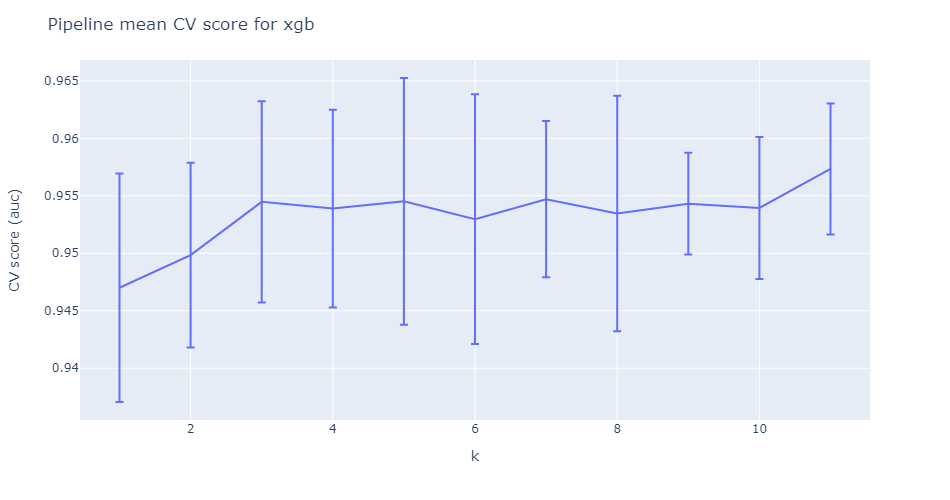

In [58]:
score_mean = xgb_mi_cv.cv_results_['mean_test_score']
score_std = xgb_mi_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb',
                  yaxis_title='CV score (f1)', width=950, height=500)

fig.show('png')

In [146]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif, k=3)), ('xgb', xgb.XGBClassifier(**best_params))]
pipeline =  Pipeline(steps)
pipeline.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oh',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['creation_source']),
                                                 ('target',
                                                  TargetEncoder(random_state=0),
                                                  ['org_id',
                                                   'invited_by_user_id'])])),
                ('selectkbest',
                 SelectKBest(k=3,
                             score_func=<function mutual_info_classif at 0x000001EBC88F4680>)),
                ('xgb',
                 XGBClassifier(...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0779959312171219, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=11,
                               max_leaves=None,
                               min_child_weight=2.861056469031193, missing=nan,
                               monotone_constraints=None, n_estimators=289,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [147]:
idx = pipeline.named_steps.selectkbest.get_support()
idx

array([False, False, False, False, False, False, False, False,  True,
        True,  True])

In [148]:
importances = pipeline.named_steps.xgb.feature_importances_
importance_xgb_mi = pd.DataFrame({'feature': pipeline.named_steps.prep.get_feature_names_out()[idx], 
                              'importance': importances})
importance_xgb_mi.feature = importance_xgb_mi.feature.str.replace('.*__','', regex=True)
top_xgb_mi = importance_xgb_mi.sort_values('importance', ascending=False)
top_xgb_mi

feature  importance
1  visited    0.729335
0   length    0.159983
2     freq    0.110682

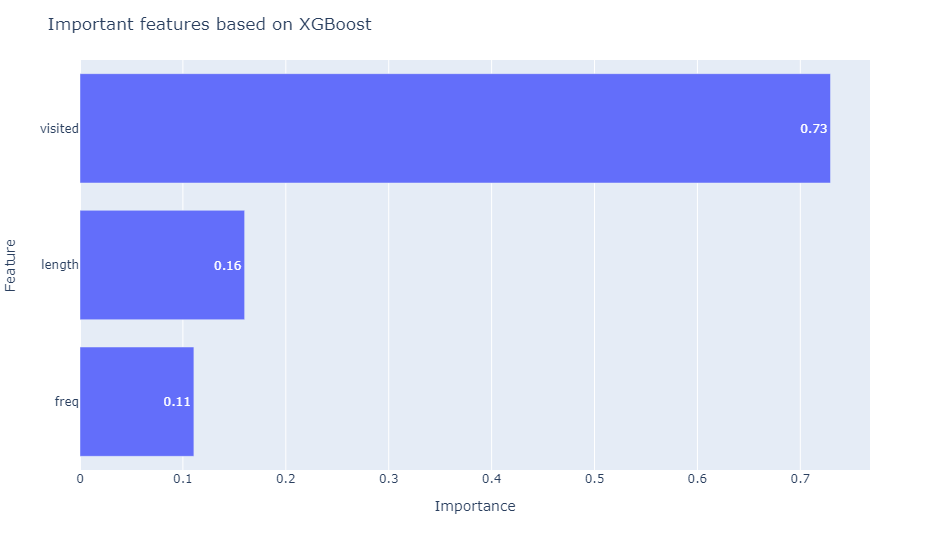

In [149]:
fig = px.bar(x=top_xgb_mi.importance[::-1], y=top_xgb_mi.feature[::-1], text_auto='.2', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')

In [150]:
y_pred = pipeline.predict(X)
y_prob = pipeline.predict_proba(X)

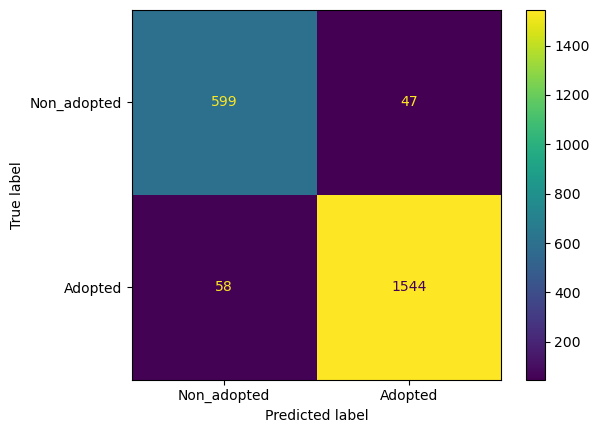

In [151]:
cm = confusion_matrix(y, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non_adopted', 'Adopted'])
cmd.plot()
plt.show()

In [152]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       646
           1       0.97      0.96      0.97      1602

    accuracy                           0.95      2248
   macro avg       0.94      0.95      0.94      2248
weighted avg       0.95      0.95      0.95      2248



In [153]:
fpr, tpr, _ = roc_curve(y, y_prob.T[1])
roc_auc = auc(fpr, tpr)
prec, recall, thresholds = precision_recall_curve(y, y_prob.T[1])
average_precision=average_precision_score(y, y_prob.T[1])
f1 = f1_score(y,y_pred)

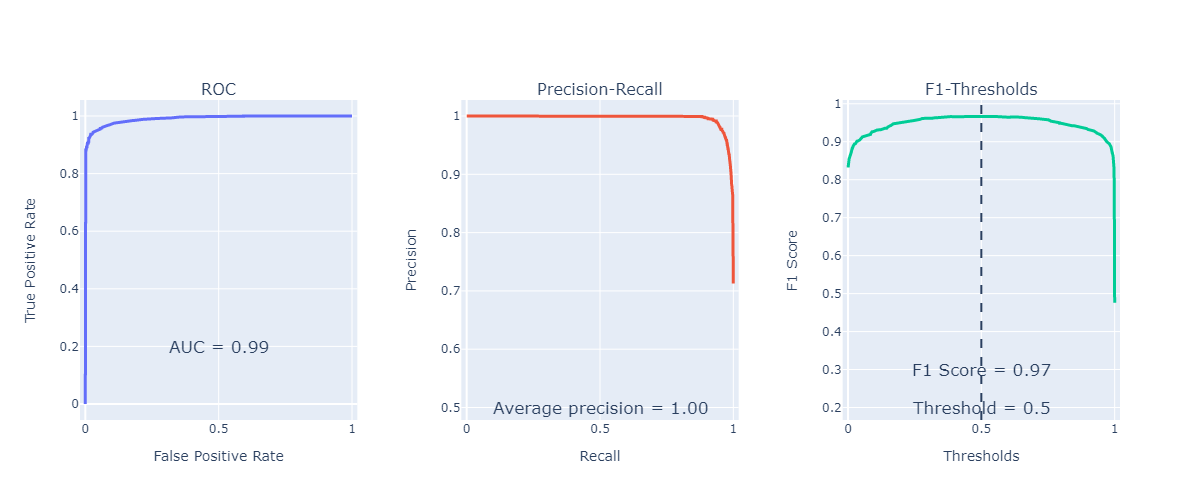

In [154]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("ROC", "Precision-Recall", 'F1-Thresholds'), 
                    horizontal_spacing=0.1)

fig.append_trace(go.Scatter(x=fpr, y=tpr, mode='lines', line={'width':3}), row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", range=[-0.02,1.02], row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.add_annotation(x=0.5, y=0.2, text=f'AUC = {roc_auc:.2f}', showarrow=False,  font={'size':17}, row=1, col=1)

fig.add_trace(go.Scatter(x=recall, y=prec, mode='lines', line={'width':3}), row=1, col=2)
fig.update_xaxes(title_text="Recall", range=[-0.02,1.02], row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)
fig.add_annotation(x=0.5, y=0.5, text=f'Average precision = {average_precision:.2f}', showarrow=False,  font={'size':17}, row=1, col=2)

fig.add_trace(go.Scatter(x=thresholds, y=2*prec[:-1]*recall[:-1]/(prec[:-1]+recall[:-1]), mode='lines', line={'width':3}), row=1, col=3)
fig.update_xaxes(title_text="Thresholds", range=[-0.02,1.02], row=1, col=3)
fig.update_yaxes(title_text="F1 Score", row=1, col=3)
fig.add_vline(x=0.5, line_width=2, line_dash="dash", row=1, col=3)
fig.add_annotation(x=0.5, y=0.3, text=f'F1 Score = {f1:.2f}', showarrow=False,  font={'size':17}, row=1, col=3)
fig.add_annotation(x=0.5, y=0.2, text=f'Threshold = 0.5', showarrow=False,  font={'size':17}, row=1, col=3)

fig.update_layout(showlegend=False,
                  template='plotly',
                  width=1200, height=500)
fig.show('png')

In [160]:
X = X.iloc[:, :-1]

In [290]:
X

creation_source  opted_in_to_mailing_list  \
1              ORG_INVITE                         0   
9              ORG_INVITE                         1   
19                 SIGNUP                         0   
32           GUEST_INVITE                         0   
41                 SIGNUP                         1   
...                   ...                       ...   
11974        GUEST_INVITE                         1   
11979          ORG_INVITE                         0   
11980        GUEST_INVITE                         0   
11987   PERSONAL_PROJECTS                         0   
11990  SIGNUP_GOOGLE_AUTH                         0   

       enabled_for_marketing_drip org_id invited_by_user_id  length  visited  
1                               0      1              316.0   136.0     14.0  
9                               1    318             4143.0   503.0    284.0  
19                              0     58                NaN    84.0      7.0  
32                              0    401               79.0    81.0     18.0  
41                              0    235                NaN   560.0    342.0  
...                           ...    ...                ...     ...      ...  
11974                           0     31             6410.0   425.0    216.0  
11979                           0    406             3068.0    75.0      8.0  
11980                           0    110             5775.0    28.0      4.0  
11987                           0    114                NaN    78.0     30.0  
11990                           0    388                NaN    40.0      5.0  

[2248 rows x 7 columns]

In [106]:
def xgb_eval1(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    
    xgb_param_grid = {'objective':'binary:logistic', 'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'gamma':gamma, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight}
    steps = [('prep', preprocessor), ('xgb', xgb.XGBClassifier(**xgb_param_grid))]
    pipeline =  Pipeline(steps)
    
    score = cross_val_score(pipeline, X, y, scoring='f1', cv=kf)
    return score.mean()

In [162]:
xgb_study1 = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study1.optimize(xgb_eval1, n_trials=1000)

[I 2024-03-08 00:00:42,606] A new study created in memory with name: no-name-134f73c3-61f9-469e-83ff-c9d87bb03344
[I 2024-03-08 00:00:43,292] Trial 0 finished with value: 0.9464379991245142 and parameters: {'n_estimators': 166, 'max_depth': 13, 'learning_rate': 0.5772328163182815, 'gamma': 0.23789282137450862, 'reg_alpha': 0.9342139979247938, 'reg_lambda': 0.613965955965896, 'subsample': 0.5402764749947088, 'colsample_bytree': 0.5940108765910252, 'min_child_weight': 7.328208092216019}. Best is trial 0 with value: 0.9464379991245142.
[I 2024-03-08 00:00:44,155] Trial 1 finished with value: 0.94661901056106 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.2098516505376324, 'gamma': 0.18619300588033616, 'reg_alpha': 0.9443723899839336, 'reg_lambda': 0.7395507950492876, 'subsample': 0.4955542205313914, 'colsample_bytree': 0.23514048169359, 'min_child_weight': 2.6181291695268905}. Best is trial 1 with value: 0.94661901056106.
[I 2024-03-08 00:00:44,610] Trial 2 finis

[I 2024-03-08 00:01:03,251] Trial 19 finished with value: 0.9338319683394622 and parameters: {'n_estimators': 111, 'max_depth': 6, 'learning_rate': 0.29333208931710697, 'gamma': 0.5547762106257408, 'reg_alpha': 0.24242852658262648, 'reg_lambda': 0.03235163498609395, 'subsample': 0.11737041239181767, 'colsample_bytree': 0.18947108894851417, 'min_child_weight': 9.189338081958734}. Best is trial 7 with value: 0.9498148755145964.
[I 2024-03-08 00:01:04,308] Trial 20 finished with value: 0.9424875693612149 and parameters: {'n_estimators': 258, 'max_depth': 16, 'learning_rate': 0.7821754553188998, 'gamma': 0.37200849943802344, 'reg_alpha': 0.09949927165032231, 'reg_lambda': 0.27784718629652816, 'subsample': 0.9688751837317022, 'colsample_bytree': 0.7111166486937297, 'min_child_weight': 7.995798740711076}. Best is trial 7 with value: 0.9498148755145964.
[I 2024-03-08 00:01:05,645] Trial 21 finished with value: 0.9489790514686847 and parameters: {'n_estimators': 399, 'max_depth': 19, 'learning

[I 2024-03-08 00:01:30,240] Trial 39 finished with value: 0.9416124322522679 and parameters: {'n_estimators': 163, 'max_depth': 14, 'learning_rate': 0.33425090139152536, 'gamma': 0.8721255471516762, 'reg_alpha': 0.546455986374729, 'reg_lambda': 0.3167346900878298, 'subsample': 0.15575404566849704, 'colsample_bytree': 0.4914445507198491, 'min_child_weight': 0.9120891107864075}. Best is trial 33 with value: 0.9502348000971385.
[I 2024-03-08 00:01:31,610] Trial 40 finished with value: 0.9479197620754146 and parameters: {'n_estimators': 423, 'max_depth': 11, 'learning_rate': 0.053347174583344426, 'gamma': 0.521530094080949, 'reg_alpha': 0.6067409373396047, 'reg_lambda': 0.0012831117808028425, 'subsample': 0.4533646712678386, 'colsample_bytree': 0.3815084646303937, 'min_child_weight': 7.8025818457489935}. Best is trial 33 with value: 0.9502348000971385.
[I 2024-03-08 00:01:33,232] Trial 41 finished with value: 0.9468808080820723 and parameters: {'n_estimators': 479, 'max_depth': 17, 'learni

[I 2024-03-08 00:01:51,914] Trial 59 finished with value: 0.9472219814016928 and parameters: {'n_estimators': 101, 'max_depth': 14, 'learning_rate': 0.5591928836698642, 'gamma': 0.6577429101488856, 'reg_alpha': 0.8567460258794255, 'reg_lambda': 0.09835342124762173, 'subsample': 0.259585946124535, 'colsample_bytree': 0.2070415535768026, 'min_child_weight': 5.877470048405955}. Best is trial 33 with value: 0.9502348000971385.
[I 2024-03-08 00:01:53,018] Trial 60 finished with value: 0.946737536430615 and parameters: {'n_estimators': 419, 'max_depth': 11, 'learning_rate': 0.6199898368530283, 'gamma': 0.5816311693701889, 'reg_alpha': 0.893013862440361, 'reg_lambda': 0.1969322571314685, 'subsample': 0.18367368839526588, 'colsample_bytree': 0.1232223791969519, 'min_child_weight': 3.767488717729922}. Best is trial 33 with value: 0.9502348000971385.
[I 2024-03-08 00:01:54,262] Trial 61 finished with value: 0.9502581685430085 and parameters: {'n_estimators': 436, 'max_depth': 17, 'learning_rate'

[I 2024-03-08 00:02:16,688] Trial 79 finished with value: 0.9507703644470002 and parameters: {'n_estimators': 359, 'max_depth': 7, 'learning_rate': 0.9625886310816744, 'gamma': 0.4702624353196438, 'reg_alpha': 0.7305128719131576, 'reg_lambda': 0.901454275368385, 'subsample': 0.841211124200254, 'colsample_bytree': 0.036250011721174126, 'min_child_weight': 4.309258770140222}. Best is trial 76 with value: 0.9529822877011069.
[I 2024-03-08 00:02:17,900] Trial 80 finished with value: 0.9470947080672453 and parameters: {'n_estimators': 349, 'max_depth': 10, 'learning_rate': 0.7938569670470703, 'gamma': 0.26501805762589753, 'reg_alpha': 0.8255344070380072, 'reg_lambda': 0.12486151001082357, 'subsample': 0.7836825302861182, 'colsample_bytree': 0.10805259595895565, 'min_child_weight': 5.55690285165293}. Best is trial 76 with value: 0.9529822877011069.
[I 2024-03-08 00:02:19,020] Trial 81 finished with value: 0.9505523207215875 and parameters: {'n_estimators': 327, 'max_depth': 8, 'learning_rate

[I 2024-03-08 00:02:41,813] Trial 99 finished with value: 0.951049167846511 and parameters: {'n_estimators': 393, 'max_depth': 10, 'learning_rate': 0.7259995467049173, 'gamma': 0.3543534459772014, 'reg_alpha': 0.519812385760207, 'reg_lambda': 0.8369733785160769, 'subsample': 0.9161378480288305, 'colsample_bytree': 0.029583419449705762, 'min_child_weight': 3.6503356675195566}. Best is trial 83 with value: 0.9535289817904944.
[I 2024-03-08 00:02:42,886] Trial 100 finished with value: 0.9505048844259306 and parameters: {'n_estimators': 315, 'max_depth': 7, 'learning_rate': 0.887136630012176, 'gamma': 0.4860689928753146, 'reg_alpha': 0.4714269117713562, 'reg_lambda': 0.8908658125385386, 'subsample': 0.9796107129933473, 'colsample_bytree': 0.06245395123339306, 'min_child_weight': 5.340959140222559}. Best is trial 83 with value: 0.9535289817904944.
[I 2024-03-08 00:02:44,054] Trial 101 finished with value: 0.9516173337421769 and parameters: {'n_estimators': 355, 'max_depth': 9, 'learning_rat

[I 2024-03-08 00:03:08,226] Trial 119 finished with value: 0.948616429777253 and parameters: {'n_estimators': 336, 'max_depth': 12, 'learning_rate': 0.9410832629149906, 'gamma': 0.3791250888325659, 'reg_alpha': 0.8297418949173996, 'reg_lambda': 0.6604853357461115, 'subsample': 0.9464146783791487, 'colsample_bytree': 0.07098759529328401, 'min_child_weight': 5.3456934056315}. Best is trial 104 with value: 0.954436343247042.
[I 2024-03-08 00:03:09,393] Trial 120 finished with value: 0.9508663970512827 and parameters: {'n_estimators': 364, 'max_depth': 12, 'learning_rate': 0.9740278999011281, 'gamma': 0.3453523318499849, 'reg_alpha': 0.7153840896302798, 'reg_lambda': 0.7072532102941951, 'subsample': 0.9035240426957495, 'colsample_bytree': 0.034578560644247, 'min_child_weight': 5.056558377416364}. Best is trial 104 with value: 0.954436343247042.
[I 2024-03-08 00:03:10,683] Trial 121 finished with value: 0.9515991283391418 and parameters: {'n_estimators': 380, 'max_depth': 13, 'learning_rate

[I 2024-03-08 00:03:33,464] Trial 139 finished with value: 0.9461131188599005 and parameters: {'n_estimators': 384, 'max_depth': 10, 'learning_rate': 0.9215926064870824, 'gamma': 0.43532912262448287, 'reg_alpha': 0.5619492290247371, 'reg_lambda': 0.560821810387699, 'subsample': 0.9524725314541523, 'colsample_bytree': 0.20190711780753773, 'min_child_weight': 2.1818910518807453}. Best is trial 131 with value: 0.9564486929609222.
[I 2024-03-08 00:03:34,900] Trial 140 finished with value: 0.9554419462653179 and parameters: {'n_estimators': 390, 'max_depth': 12, 'learning_rate': 0.9467546309190898, 'gamma': 0.42279711574393153, 'reg_alpha': 0.6520811577055681, 'reg_lambda': 0.6204810847364761, 'subsample': 0.9993133725385984, 'colsample_bytree': 0.18368547817577507, 'min_child_weight': 1.6450373647845127}. Best is trial 131 with value: 0.9564486929609222.
[I 2024-03-08 00:03:36,452] Trial 141 finished with value: 0.9528780823450042 and parameters: {'n_estimators': 387, 'max_depth': 12, 'lea

[I 2024-03-08 00:04:02,473] Trial 159 finished with value: 0.9433881858367636 and parameters: {'n_estimators': 458, 'max_depth': 14, 'learning_rate': 0.9383338980486304, 'gamma': 0.4711264974219709, 'reg_alpha': 0.6076959640413646, 'reg_lambda': 0.5996008645037385, 'subsample': 0.9548182075750995, 'colsample_bytree': 0.2021404321682907, 'min_child_weight': 1.445189277125911}. Best is trial 131 with value: 0.9564486929609222.
[I 2024-03-08 00:04:04,074] Trial 160 finished with value: 0.9468169777752289 and parameters: {'n_estimators': 427, 'max_depth': 14, 'learning_rate': 0.9111678466591695, 'gamma': 0.40440992778092894, 'reg_alpha': 0.6346126653845895, 'reg_lambda': 0.5552623463379676, 'subsample': 0.9358405137385538, 'colsample_bytree': 0.2859991367878877, 'min_child_weight': 0.8939456950104887}. Best is trial 131 with value: 0.9564486929609222.
[I 2024-03-08 00:04:05,510] Trial 161 finished with value: 0.9532596642147066 and parameters: {'n_estimators': 444, 'max_depth': 15, 'learni

[I 2024-03-08 00:04:35,182] Trial 179 finished with value: 0.9532141345060511 and parameters: {'n_estimators': 481, 'max_depth': 16, 'learning_rate': 0.9498310417245217, 'gamma': 0.5598923698274912, 'reg_alpha': 0.6940565310214935, 'reg_lambda': 0.6470724303277929, 'subsample': 0.9727798216422426, 'colsample_bytree': 0.18487060655245866, 'min_child_weight': 2.6113269107910577}. Best is trial 163 with value: 0.956483871183425.
[I 2024-03-08 00:04:36,632] Trial 180 finished with value: 0.9502409561149922 and parameters: {'n_estimators': 458, 'max_depth': 15, 'learning_rate': 0.9275107264049326, 'gamma': 0.44324869398838024, 'reg_alpha': 0.6743142433912785, 'reg_lambda': 0.6657397672568871, 'subsample': 0.92909193412763, 'colsample_bytree': 0.11041973352871569, 'min_child_weight': 1.0776156995130186}. Best is trial 163 with value: 0.956483871183425.
[I 2024-03-08 00:04:38,151] Trial 181 finished with value: 0.9548280020752233 and parameters: {'n_estimators': 477, 'max_depth': 16, 'learnin

[I 2024-03-08 00:05:07,003] Trial 199 finished with value: 0.9536336948265915 and parameters: {'n_estimators': 471, 'max_depth': 18, 'learning_rate': 0.8966154072555512, 'gamma': 0.39944875880137437, 'reg_alpha': 0.6284122690570935, 'reg_lambda': 0.6860419128293228, 'subsample': 0.9515339999427056, 'colsample_bytree': 0.1600832106522557, 'min_child_weight': 2.307390744097487}. Best is trial 163 with value: 0.956483871183425.
[I 2024-03-08 00:05:08,536] Trial 200 finished with value: 0.9549071528067218 and parameters: {'n_estimators': 478, 'max_depth': 18, 'learning_rate': 0.9304706501605201, 'gamma': 0.41676428894964507, 'reg_alpha': 0.5622904305254521, 'reg_lambda': 0.6325899536184787, 'subsample': 0.9998185318717522, 'colsample_bytree': 0.1838332871494915, 'min_child_weight': 1.2190679792321446}. Best is trial 163 with value: 0.956483871183425.
[I 2024-03-08 00:05:10,053] Trial 201 finished with value: 0.9564890690241971 and parameters: {'n_estimators': 480, 'max_depth': 18, 'learnin

[I 2024-03-08 00:05:39,378] Trial 219 finished with value: 0.9551474693681863 and parameters: {'n_estimators': 455, 'max_depth': 17, 'learning_rate': 0.958459554436538, 'gamma': 0.4466558401811633, 'reg_alpha': 0.6803639615506729, 'reg_lambda': 0.6286378385240535, 'subsample': 0.9998589544787013, 'colsample_bytree': 0.15780563930646874, 'min_child_weight': 1.196898507829093}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:05:40,848] Trial 220 finished with value: 0.9551315476260942 and parameters: {'n_estimators': 461, 'max_depth': 17, 'learning_rate': 0.9381357046809987, 'gamma': 0.4454511174473506, 'reg_alpha': 0.6815584680240837, 'reg_lambda': 0.6268758082366622, 'subsample': 0.972159552667188, 'colsample_bytree': 0.10937530277817742, 'min_child_weight': 1.2183476080692028}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:05:43,277] Trial 221 finished with value: 0.9452859633066453 and parameters: {'n_estimators': 465, 'max_depth': 17, 'learnin

[I 2024-03-08 00:06:11,919] Trial 239 finished with value: 0.9524092250785131 and parameters: {'n_estimators': 484, 'max_depth': 17, 'learning_rate': 0.936621777094703, 'gamma': 0.38829863334124437, 'reg_alpha': 0.6703227320693484, 'reg_lambda': 0.6317927560906961, 'subsample': 0.944346119050422, 'colsample_bytree': 0.18786026454968047, 'min_child_weight': 1.752887891763462}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:06:13,473] Trial 240 finished with value: 0.9519684755763324 and parameters: {'n_estimators': 472, 'max_depth': 17, 'learning_rate': 0.9107141287800583, 'gamma': 0.407688478414594, 'reg_alpha': 0.6485527668524087, 'reg_lambda': 0.5891803494022924, 'subsample': 0.9676082307267762, 'colsample_bytree': 0.0947381836596318, 'min_child_weight': 0.3550065087249257}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:06:15,217] Trial 241 finished with value: 0.9542632112308553 and parameters: {'n_estimators': 465, 'max_depth': 18, 'learning

[I 2024-03-08 00:06:42,860] Trial 259 finished with value: 0.9488066313293512 and parameters: {'n_estimators': 491, 'max_depth': 18, 'learning_rate': 0.8822426156870065, 'gamma': 0.4282087744991986, 'reg_alpha': 0.7125331060499073, 'reg_lambda': 0.6778593916953348, 'subsample': 0.9252088037852688, 'colsample_bytree': 0.20260874170983648, 'min_child_weight': 1.1695831537054389}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:06:45,111] Trial 260 finished with value: 0.9454555394198609 and parameters: {'n_estimators': 452, 'max_depth': 18, 'learning_rate': 0.922564845582968, 'gamma': 0.39155843024783343, 'reg_alpha': 0.6724521490938331, 'reg_lambda': 0.637307321863334, 'subsample': 0.9639756842522733, 'colsample_bytree': 0.9365291369128714, 'min_child_weight': 2.014816444931809}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:06:46,794] Trial 261 finished with value: 0.9557623853661115 and parameters: {'n_estimators': 463, 'max_depth': 18, 'learnin

[I 2024-03-08 00:07:18,134] Trial 279 finished with value: 0.9536219053744841 and parameters: {'n_estimators': 452, 'max_depth': 18, 'learning_rate': 0.8422076708438364, 'gamma': 0.3678191173486078, 'reg_alpha': 0.6755382996437452, 'reg_lambda': 0.6852402544786897, 'subsample': 0.9807972664447175, 'colsample_bytree': 0.16578500525242765, 'min_child_weight': 1.4197735402335214}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:07:20,735] Trial 280 finished with value: 0.9522791698781514 and parameters: {'n_estimators': 484, 'max_depth': 19, 'learning_rate': 0.8988773996306405, 'gamma': 0.4750641664764528, 'reg_alpha': 0.7092321593943421, 'reg_lambda': 0.6584644900224546, 'subsample': 0.9633617518864045, 'colsample_bytree': 0.1808437767916443, 'min_child_weight': 1.0008477800030715}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:07:22,760] Trial 281 finished with value: 0.953927744093553 and parameters: {'n_estimators': 438, 'max_depth': 18, 'learni

[I 2024-03-08 00:07:59,069] Trial 299 finished with value: 0.9533851051486615 and parameters: {'n_estimators': 491, 'max_depth': 19, 'learning_rate': 0.8813004374112748, 'gamma': 0.47155840614684147, 'reg_alpha': 0.6858053457270717, 'reg_lambda': 0.6594472410520114, 'subsample': 0.982178193514116, 'colsample_bytree': 0.07070905859308511, 'min_child_weight': 1.4502634391208629}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:08:01,412] Trial 300 finished with value: 0.9445936448685623 and parameters: {'n_estimators': 443, 'max_depth': 18, 'learning_rate': 0.9260078891593984, 'gamma': 0.37746061664914166, 'reg_alpha': 0.6231283377611835, 'reg_lambda': 0.699139997610044, 'subsample': 0.9475290048871614, 'colsample_bytree': 0.378615921910804, 'min_child_weight': 1.151065511204839}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:08:03,293] Trial 301 finished with value: 0.9536775703216209 and parameters: {'n_estimators': 481, 'max_depth': 18, 'learnin

[I 2024-03-08 00:08:41,308] Trial 319 finished with value: 0.948437747182499 and parameters: {'n_estimators': 468, 'max_depth': 20, 'learning_rate': 0.6041164142103591, 'gamma': 0.3656146158833221, 'reg_alpha': 0.5149844981130928, 'reg_lambda': 0.6932211530915708, 'subsample': 0.42647047243675684, 'colsample_bytree': 0.16860057551514637, 'min_child_weight': 1.495123933877702}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:08:43,039] Trial 320 finished with value: 0.952762497024161 and parameters: {'n_estimators': 480, 'max_depth': 17, 'learning_rate': 0.8289623609119653, 'gamma': 0.4352950461570506, 'reg_alpha': 0.7188549944646198, 'reg_lambda': 0.6025031747462832, 'subsample': 0.9499369889928982, 'colsample_bytree': 0.10292906010542234, 'min_child_weight': 7.099473533974797}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:08:44,757] Trial 321 finished with value: 0.9483181863615032 and parameters: {'n_estimators': 440, 'max_depth': 19, 'learnin

[I 2024-03-08 00:09:19,218] Trial 339 finished with value: 0.950859360247095 and parameters: {'n_estimators': 484, 'max_depth': 10, 'learning_rate': 0.9564295749520719, 'gamma': 0.37248055919166645, 'reg_alpha': 0.6288357987195885, 'reg_lambda': 0.6387337353567597, 'subsample': 0.9677275633518153, 'colsample_bytree': 0.11505387365616501, 'min_child_weight': 1.3772789495831823}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:09:21,049] Trial 340 finished with value: 0.9517583079970061 and parameters: {'n_estimators': 478, 'max_depth': 18, 'learning_rate': 0.9127498947036536, 'gamma': 0.3052870357953438, 'reg_alpha': 0.6845748798934049, 'reg_lambda': 0.7255906732789972, 'subsample': 0.9260224699795412, 'colsample_bytree': 0.13406341243686035, 'min_child_weight': 0.8433278267787472}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:09:22,965] Trial 341 finished with value: 0.9539757867248421 and parameters: {'n_estimators': 492, 'max_depth': 11, 'lear

[I 2024-03-08 00:09:58,418] Trial 359 finished with value: 0.9529652087815995 and parameters: {'n_estimators': 401, 'max_depth': 13, 'learning_rate': 0.8818487608522174, 'gamma': 0.3628818638664783, 'reg_alpha': 0.6215897816602545, 'reg_lambda': 0.6919128140724731, 'subsample': 0.9662768006976626, 'colsample_bytree': 0.1606880773332876, 'min_child_weight': 0.7176926844741086}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:10:00,856] Trial 360 finished with value: 0.9530030293960436 and parameters: {'n_estimators': 493, 'max_depth': 17, 'learning_rate': 0.9606846435914345, 'gamma': 0.4724229971657645, 'reg_alpha': 0.6033174641510348, 'reg_lambda': 0.7516747167248644, 'subsample': 0.9450468004658908, 'colsample_bytree': 0.19389076333381103, 'min_child_weight': 1.1681055788475374}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:10:02,715] Trial 361 finished with value: 0.952039343553311 and parameters: {'n_estimators': 474, 'max_depth': 10, 'learni

[I 2024-03-08 00:10:37,687] Trial 379 finished with value: 0.9483727448992237 and parameters: {'n_estimators': 464, 'max_depth': 19, 'learning_rate': 0.49811114865087, 'gamma': 0.3777407661714001, 'reg_alpha': 0.6314405714725932, 'reg_lambda': 0.6444885565282517, 'subsample': 0.5660600430202436, 'colsample_bytree': 0.09822220064877929, 'min_child_weight': 0.8471172195446847}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:10:39,899] Trial 380 finished with value: 0.9539333653712581 and parameters: {'n_estimators': 492, 'max_depth': 18, 'learning_rate': 0.9477733233078749, 'gamma': 0.4432091764270139, 'reg_alpha': 0.6701933506190013, 'reg_lambda': 0.705473922122111, 'subsample': 0.9992600189895016, 'colsample_bytree': 0.13361817470629178, 'min_child_weight': 1.3570577434029594}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:10:41,772] Trial 381 finished with value: 0.9490997173454601 and parameters: {'n_estimators': 420, 'max_depth': 17, 'learnin

[I 2024-03-08 00:11:11,561] Trial 399 finished with value: 0.9523630567663368 and parameters: {'n_estimators': 312, 'max_depth': 16, 'learning_rate': 0.9633927983977316, 'gamma': 0.14138177417874248, 'reg_alpha': 0.7668455361130098, 'reg_lambda': 0.7453549922311934, 'subsample': 0.967063750002063, 'colsample_bytree': 0.04348588923795696, 'min_child_weight': 0.3985494193627479}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:11:12,941] Trial 400 finished with value: 0.9559424965704352 and parameters: {'n_estimators': 328, 'max_depth': 15, 'learning_rate': 0.9590627432849548, 'gamma': 0.12699501814456818, 'reg_alpha': 0.7429839854281143, 'reg_lambda': 0.6954945465930167, 'subsample': 0.9998304250810667, 'colsample_bytree': 0.043518391883380456, 'min_child_weight': 0.7923966676372185}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:11:14,266] Trial 401 finished with value: 0.9439684956353549 and parameters: {'n_estimators': 320, 'max_depth': 15, 'le

[I 2024-03-08 00:11:38,824] Trial 418 finished with value: 0.9555681350166971 and parameters: {'n_estimators': 330, 'max_depth': 16, 'learning_rate': 0.9618943246546712, 'gamma': 0.14419773493784369, 'reg_alpha': 0.7754077035163701, 'reg_lambda': 0.6787288375124737, 'subsample': 0.9992095622726468, 'colsample_bytree': 0.044227355848507885, 'min_child_weight': 0.7435440760053121}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:11:40,157] Trial 419 finished with value: 0.9549546163057215 and parameters: {'n_estimators': 307, 'max_depth': 16, 'learning_rate': 0.9705099562680213, 'gamma': 0.18881468539366536, 'reg_alpha': 0.8149308745327565, 'reg_lambda': 0.7577013447684535, 'subsample': 0.9991364997744625, 'colsample_bytree': 0.04295739397089533, 'min_child_weight': 0.7743877735178362}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:11:41,656] Trial 420 finished with value: 0.9546359071588171 and parameters: {'n_estimators': 327, 'max_depth': 16, 'l

[I 2024-03-08 00:12:07,075] Trial 437 finished with value: 0.9486260463768691 and parameters: {'n_estimators': 339, 'max_depth': 15, 'learning_rate': 0.9581442717381458, 'gamma': 0.1016839653174136, 'reg_alpha': 0.523132215721882, 'reg_lambda': 0.7356811758395633, 'subsample': 0.9186794771259909, 'colsample_bytree': 0.03351399113158701, 'min_child_weight': 0.5508717001142697}. Best is trial 201 with value: 0.9564890690241971.
[I 2024-03-08 00:12:08,847] Trial 438 finished with value: 0.9567941308769973 and parameters: {'n_estimators': 332, 'max_depth': 17, 'learning_rate': 0.9289638341530856, 'gamma': 0.18027462792079985, 'reg_alpha': 0.6930025466654788, 'reg_lambda': 0.7857967471856995, 'subsample': 0.9999133482617928, 'colsample_bytree': 0.08012368186809352, 'min_child_weight': 0.7789967058741122}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:12:10,286] Trial 439 finished with value: 0.9523727220805853 and parameters: {'n_estimators': 300, 'max_depth': 17, 'lear

[I 2024-03-08 00:12:38,926] Trial 457 finished with value: 0.9482692185599342 and parameters: {'n_estimators': 482, 'max_depth': 17, 'learning_rate': 0.9754551916577049, 'gamma': 0.11233870847893901, 'reg_alpha': 0.10072680053760052, 'reg_lambda': 0.6963756914064958, 'subsample': 0.9991209134134359, 'colsample_bytree': 0.08869660327397284, 'min_child_weight': 0.9985760078169863}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:12:40,788] Trial 458 finished with value: 0.9510095315369137 and parameters: {'n_estimators': 330, 'max_depth': 19, 'learning_rate': 0.9018955939807688, 'gamma': 0.15868581719786576, 'reg_alpha': 0.6758115495160388, 'reg_lambda': 0.7392565053901742, 'subsample': 0.9425041325853759, 'colsample_bytree': 0.06161540427287621, 'min_child_weight': 0.7538850219443655}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:12:42,718] Trial 459 finished with value: 0.9555470529564973 and parameters: {'n_estimators': 457, 'max_depth': 15, 'l

[I 2024-03-08 00:13:18,085] Trial 477 finished with value: 0.9539463900158361 and parameters: {'n_estimators': 334, 'max_depth': 15, 'learning_rate': 0.9608224189046979, 'gamma': 0.45471121447544693, 'reg_alpha': 0.6978762859871182, 'reg_lambda': 0.756502343475044, 'subsample': 0.9999693764751222, 'colsample_bytree': 0.10181886857219644, 'min_child_weight': 1.0467060637008174}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:13:19,524] Trial 478 finished with value: 0.9512883566763402 and parameters: {'n_estimators': 301, 'max_depth': 18, 'learning_rate': 0.9134094073429633, 'gamma': 0.13899166108447178, 'reg_alpha': 0.6509976898535936, 'reg_lambda': 0.27653779549166774, 'subsample': 0.968556084539441, 'colsample_bytree': 0.026090351722282232, 'min_child_weight': 0.7570050354286674}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:13:21,392] Trial 479 finished with value: 0.9537355070577392 and parameters: {'n_estimators': 448, 'max_depth': 20, 'le

[I 2024-03-08 00:13:58,982] Trial 497 finished with value: 0.9545794803049678 and parameters: {'n_estimators': 460, 'max_depth': 15, 'learning_rate': 0.8914240194399504, 'gamma': 0.9750870123800836, 'reg_alpha': 0.7736180239636216, 'reg_lambda': 0.7696266954455894, 'subsample': 0.9261064768445915, 'colsample_bytree': 0.13235018971705512, 'min_child_weight': 0.7612782937316777}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:14:02,402] Trial 498 finished with value: 0.9518547850221045 and parameters: {'n_estimators': 446, 'max_depth': 14, 'learning_rate': 0.8616819259374093, 'gamma': 0.958791170275965, 'reg_alpha': 0.7574219315468359, 'reg_lambda': 0.7596813111890784, 'subsample': 0.9466953073161879, 'colsample_bytree': 0.4710227994205174, 'min_child_weight': 0.9681939594450062}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:14:04,591] Trial 499 finished with value: 0.9543599904627641 and parameters: {'n_estimators': 465, 'max_depth': 14, 'learni

[I 2024-03-08 00:14:44,412] Trial 517 finished with value: 0.9532934894249371 and parameters: {'n_estimators': 347, 'max_depth': 16, 'learning_rate': 0.938134364569475, 'gamma': 0.6755860098190969, 'reg_alpha': 0.6965823763898615, 'reg_lambda': 0.6577533242558082, 'subsample': 0.9999871839134697, 'colsample_bytree': 0.09034353797881041, 'min_child_weight': 1.1718630956145129}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:14:46,633] Trial 518 finished with value: 0.9546718143473167 and parameters: {'n_estimators': 467, 'max_depth': 18, 'learning_rate': 0.9531695572387497, 'gamma': 0.46736827791991453, 'reg_alpha': 0.6488677419059949, 'reg_lambda': 0.7456936913144813, 'subsample': 0.9569455117175804, 'colsample_bytree': 0.1441435775896203, 'min_child_weight': 0.7034817763649537}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:14:49,276] Trial 519 finished with value: 0.9436475980455151 and parameters: {'n_estimators': 485, 'max_depth': 17, 'learn

[I 2024-03-08 00:15:28,759] Trial 537 finished with value: 0.9515292880118149 and parameters: {'n_estimators': 459, 'max_depth': 17, 'learning_rate': 0.8991629011422915, 'gamma': 0.3823959464075765, 'reg_alpha': 0.8264749714969927, 'reg_lambda': 0.6746169274609658, 'subsample': 0.9563781799800013, 'colsample_bytree': 0.011168890308844173, 'min_child_weight': 6.058772453116558}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:15:30,848] Trial 538 finished with value: 0.9528022272508055 and parameters: {'n_estimators': 475, 'max_depth': 17, 'learning_rate': 0.9135921090766769, 'gamma': 0.4068150698656672, 'reg_alpha': 0.813131584372873, 'reg_lambda': 0.62372426984048, 'subsample': 0.9093635383739782, 'colsample_bytree': 0.010452384284822161, 'min_child_weight': 1.6468093344018118}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:15:32,694] Trial 539 finished with value: 0.9411541073022708 and parameters: {'n_estimators': 453, 'max_depth': 18, 'learni

[I 2024-03-08 00:16:11,644] Trial 557 finished with value: 0.9438086706921378 and parameters: {'n_estimators': 473, 'max_depth': 16, 'learning_rate': 0.8994084652667258, 'gamma': 0.3034311532254459, 'reg_alpha': 0.6121535647010892, 'reg_lambda': 0.6699567562891604, 'subsample': 0.4775149366561196, 'colsample_bytree': 0.14866959980362016, 'min_child_weight': 1.8603467403062437}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:16:13,429] Trial 558 finished with value: 0.9555214902003824 and parameters: {'n_estimators': 341, 'max_depth': 17, 'learning_rate': 0.8728021085587716, 'gamma': 0.9977188191906897, 'reg_alpha': 0.8201426150240068, 'reg_lambda': 0.6446819096037517, 'subsample': 0.9688433485340907, 'colsample_bytree': 0.13171557247517976, 'min_child_weight': 0.9555751376042024}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:16:15,595] Trial 559 finished with value: 0.9558826454165172 and parameters: {'n_estimators': 457, 'max_depth': 15, 'lear

[I 2024-03-08 00:16:50,984] Trial 576 finished with value: 0.9550188464681831 and parameters: {'n_estimators': 325, 'max_depth': 14, 'learning_rate': 0.9240409774555696, 'gamma': 0.21261245535225626, 'reg_alpha': 0.9594807852009419, 'reg_lambda': 0.6728947638508802, 'subsample': 0.9997849566226167, 'colsample_bytree': 0.11287050781503405, 'min_child_weight': 0.7126488248640374}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:16:52,653] Trial 577 finished with value: 0.9533635788514581 and parameters: {'n_estimators': 345, 'max_depth': 16, 'learning_rate': 0.9074008564502999, 'gamma': 0.17749156233938884, 'reg_alpha': 0.9389543928448472, 'reg_lambda': 0.7187905669074861, 'subsample': 0.968060098175946, 'colsample_bytree': 0.06971743507321279, 'min_child_weight': 0.14010008631957138}. Best is trial 438 with value: 0.9567941308769973.
[I 2024-03-08 00:16:54,874] Trial 578 finished with value: 0.9502520889925685 and parameters: {'n_estimators': 460, 'max_depth': 16, 'le

[I 2024-03-08 00:17:29,209] Trial 596 finished with value: 0.9555578638675973 and parameters: {'n_estimators': 451, 'max_depth': 15, 'learning_rate': 0.9725130130066154, 'gamma': 0.28028812474272563, 'reg_alpha': 0.9759092947848304, 'reg_lambda': 0.676009312166694, 'subsample': 0.999818972660198, 'colsample_bytree': 0.05587358821707503, 'min_child_weight': 0.7255683549910245}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:17:30,727] Trial 597 finished with value: 0.9493238046201713 and parameters: {'n_estimators': 308, 'max_depth': 14, 'learning_rate': 0.9292223731317193, 'gamma': 0.33947474793435983, 'reg_alpha': 0.9500116903395621, 'reg_lambda': 0.7432904799622196, 'subsample': 0.9484745153303971, 'colsample_bytree': 0.0731721526301454, 'min_child_weight': 8.381084477285762}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:17:32,880] Trial 598 finished with value: 0.9504722952010223 and parameters: {'n_estimators': 483, 'max_depth': 15, 'learni

[I 2024-03-08 00:18:13,245] Trial 616 finished with value: 0.9552349119297219 and parameters: {'n_estimators': 496, 'max_depth': 15, 'learning_rate': 0.9626598689908081, 'gamma': 0.279553058115393, 'reg_alpha': 0.8511163513651129, 'reg_lambda': 0.6353913215613218, 'subsample': 0.984719386191616, 'colsample_bytree': 0.08526523106301906, 'min_child_weight': 0.4702915686469187}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:18:15,808] Trial 617 finished with value: 0.9521698135030953 and parameters: {'n_estimators': 475, 'max_depth': 15, 'learning_rate': 0.9188836769765046, 'gamma': 0.23958765747622918, 'reg_alpha': 0.8463275364110462, 'reg_lambda': 0.6748341987231046, 'subsample': 0.9383497334960801, 'colsample_bytree': 0.0469958280355256, 'min_child_weight': 0.7668104488606273}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:18:18,266] Trial 618 finished with value: 0.9555957480766433 and parameters: {'n_estimators': 482, 'max_depth': 14, 'learni

[I 2024-03-08 00:19:00,887] Trial 636 finished with value: 0.9511964027318804 and parameters: {'n_estimators': 468, 'max_depth': 15, 'learning_rate': 0.9121312124675742, 'gamma': 0.2265562550464024, 'reg_alpha': 0.9207562948309953, 'reg_lambda': 0.6268396074108565, 'subsample': 0.9334764501212034, 'colsample_bytree': 0.12634560129577346, 'min_child_weight': 0.9812975154014477}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:19:03,410] Trial 637 finished with value: 0.9558194879658835 and parameters: {'n_estimators': 479, 'max_depth': 15, 'learning_rate': 0.864642600400439, 'gamma': 0.30232524337496264, 'reg_alpha': 0.952311888203608, 'reg_lambda': 0.6059814062753272, 'subsample': 0.9639727475499836, 'colsample_bytree': 0.10723073426498039, 'min_child_weight': 1.1369167866538787}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:19:06,119] Trial 638 finished with value: 0.955621675131653 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learni

[I 2024-03-08 00:19:45,499] Trial 656 finished with value: 0.9439375129240799 and parameters: {'n_estimators': 436, 'max_depth': 14, 'learning_rate': 0.8525211738863276, 'gamma': 0.2626635507179188, 'reg_alpha': 0.9985954606651394, 'reg_lambda': 0.9255655150820319, 'subsample': 0.09456507023693345, 'colsample_bytree': 0.16722394725030487, 'min_child_weight': 1.363369052555333}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:19:47,571] Trial 657 finished with value: 0.9545329820733093 and parameters: {'n_estimators': 435, 'max_depth': 13, 'learning_rate': 0.8578284814399614, 'gamma': 0.3152585142890746, 'reg_alpha': 0.9679920131612307, 'reg_lambda': 0.868744383286941, 'subsample': 0.9999969570356682, 'colsample_bytree': 0.19473291258882275, 'min_child_weight': 1.7016920075502004}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:19:49,608] Trial 658 finished with value: 0.954869284277837 and parameters: {'n_estimators': 436, 'max_depth': 13, 'learni

[I 2024-03-08 00:20:28,532] Trial 676 finished with value: 0.952438322821483 and parameters: {'n_estimators': 452, 'max_depth': 16, 'learning_rate': 0.9242769269427086, 'gamma': 0.29968427662260416, 'reg_alpha': 0.9557816583304798, 'reg_lambda': 0.6121268384085452, 'subsample': 0.9421094390581634, 'colsample_bytree': 0.13482299263017725, 'min_child_weight': 1.5006344858796286}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:20:32,058] Trial 677 finished with value: 0.9469297944354258 and parameters: {'n_estimators': 441, 'max_depth': 15, 'learning_rate': 0.893819524060165, 'gamma': 0.27415816852415176, 'reg_alpha': 0.4468180082311351, 'reg_lambda': 0.5899987310659571, 'subsample': 0.9657127845485248, 'colsample_bytree': 0.9778589475562574, 'min_child_weight': 1.0089629795262747}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:20:34,269] Trial 678 finished with value: 0.9552755976257 and parameters: {'n_estimators': 484, 'max_depth': 17, 'learning

[I 2024-03-08 00:21:17,097] Trial 696 finished with value: 0.9545945348674139 and parameters: {'n_estimators': 493, 'max_depth': 16, 'learning_rate': 0.9098301448775015, 'gamma': 0.37106470761757565, 'reg_alpha': 0.9990384127458737, 'reg_lambda': 0.48978742823384536, 'subsample': 0.9825650831131645, 'colsample_bytree': 0.10808723317326428, 'min_child_weight': 1.4109071891645881}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:21:19,272] Trial 697 finished with value: 0.9544305070658312 and parameters: {'n_estimators': 473, 'max_depth': 15, 'learning_rate': 0.9414042189350346, 'gamma': 0.3433540106323657, 'reg_alpha': 0.8625550230948031, 'reg_lambda': 0.5521781070282131, 'subsample': 0.94457931628205, 'colsample_bytree': 0.14159711064245972, 'min_child_weight': 1.6313900238654524}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:21:20,493] Trial 698 finished with value: 0.9499201082402973 and parameters: {'n_estimators': 187, 'max_depth': 15, 'lear

[I 2024-03-08 00:22:04,862] Trial 716 finished with value: 0.9533302689465752 and parameters: {'n_estimators': 487, 'max_depth': 14, 'learning_rate': 0.9209770882224287, 'gamma': 0.349082232168515, 'reg_alpha': 0.9663773216392834, 'reg_lambda': 0.47910241511020035, 'subsample': 0.9416850616097697, 'colsample_bytree': 0.16485125473228235, 'min_child_weight': 0.9838874206271813}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:22:07,136] Trial 717 finished with value: 0.9558290887927635 and parameters: {'n_estimators': 495, 'max_depth': 15, 'learning_rate': 0.9499363828482245, 'gamma': 0.2856418917695268, 'reg_alpha': 0.9994682498805489, 'reg_lambda': 0.5423196485062003, 'subsample': 0.9817208058410277, 'colsample_bytree': 0.14283589532873497, 'min_child_weight': 0.6848809892373547}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:22:09,515] Trial 718 finished with value: 0.9530822251441414 and parameters: {'n_estimators': 486, 'max_depth': 15, 'lear

[I 2024-03-08 00:22:52,275] Trial 736 finished with value: 0.9568267390252624 and parameters: {'n_estimators': 474, 'max_depth': 15, 'learning_rate': 0.9429174445520537, 'gamma': 0.27592485872985406, 'reg_alpha': 0.9429143074277918, 'reg_lambda': 0.9681223814797428, 'subsample': 0.9992376584107251, 'colsample_bytree': 0.09762445537402595, 'min_child_weight': 0.7515850760442162}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:22:54,548] Trial 737 finished with value: 0.9568126286236402 and parameters: {'n_estimators': 473, 'max_depth': 15, 'learning_rate': 0.9098081733026684, 'gamma': 0.2704452663770863, 'reg_alpha': 0.9087459083185061, 'reg_lambda': 0.8998445697122722, 'subsample': 0.9836237726551909, 'colsample_bytree': 0.10846179680357859, 'min_child_weight': 0.8620469549585897}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:22:56,817] Trial 738 finished with value: 0.954393737433427 and parameters: {'n_estimators': 473, 'max_depth': 15, 'lear

[I 2024-03-08 00:23:39,029] Trial 756 finished with value: 0.9539079099702142 and parameters: {'n_estimators': 463, 'max_depth': 15, 'learning_rate': 0.9037366812687642, 'gamma': 0.30779354102483597, 'reg_alpha': 0.9575281670440463, 'reg_lambda': 0.9133670790753782, 'subsample': 0.9803364094469026, 'colsample_bytree': 0.07796717376744919, 'min_child_weight': 3.180631723134039}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:23:41,417] Trial 757 finished with value: 0.9531390740551648 and parameters: {'n_estimators': 483, 'max_depth': 14, 'learning_rate': 0.950310240839271, 'gamma': 0.2610965493255115, 'reg_alpha': 0.9368113197007233, 'reg_lambda': 0.9559163158673747, 'subsample': 0.9288127569983169, 'colsample_bytree': 0.1050187003789391, 'min_child_weight': 0.4905936739324478}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:23:43,802] Trial 758 finished with value: 0.9564820784483746 and parameters: {'n_estimators': 485, 'max_depth': 15, 'learni

[I 2024-03-08 00:24:28,889] Trial 776 finished with value: 0.9537905171715331 and parameters: {'n_estimators': 383, 'max_depth': 15, 'learning_rate': 0.9511881261391013, 'gamma': 0.23369398389412752, 'reg_alpha': 0.9338169053167367, 'reg_lambda': 0.8224720074145966, 'subsample': 0.9145497036869096, 'colsample_bytree': 0.12238907270648666, 'min_child_weight': 0.47510693737148024}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:24:31,209] Trial 777 finished with value: 0.9556004874236841 and parameters: {'n_estimators': 460, 'max_depth': 12, 'learning_rate': 0.8730169577809591, 'gamma': 0.29040793177560115, 'reg_alpha': 0.9661566020992506, 'reg_lambda': 0.9256621155982, 'subsample': 0.9811614351705938, 'colsample_bytree': 0.1991767848898194, 'min_child_weight': 0.9787556897214644}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:24:34,722] Trial 778 finished with value: 0.9467539755326333 and parameters: {'n_estimators': 468, 'max_depth': 16, 'learn

[I 2024-03-08 00:25:17,143] Trial 796 finished with value: 0.9477294411397793 and parameters: {'n_estimators': 418, 'max_depth': 15, 'learning_rate': 0.9811132074759438, 'gamma': 0.21422080238467575, 'reg_alpha': 0.935338283189696, 'reg_lambda': 0.9329082078491344, 'subsample': 0.9999431013925818, 'colsample_bytree': 0.48268852074270296, 'min_child_weight': 1.0915574470071814}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:25:19,751] Trial 797 finished with value: 0.9497585241964254 and parameters: {'n_estimators': 481, 'max_depth': 16, 'learning_rate': 0.9270980903174462, 'gamma': 0.30600923916065886, 'reg_alpha': 0.8946785169297821, 'reg_lambda': 0.9119038867045866, 'subsample': 0.9992114811562598, 'colsample_bytree': 0.1173123931314914, 'min_child_weight': 5.396913478146219}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:25:22,295] Trial 798 finished with value: 0.9547414841056788 and parameters: {'n_estimators': 467, 'max_depth': 14, 'learn

[I 2024-03-08 00:26:04,905] Trial 816 finished with value: 0.9543099858192383 and parameters: {'n_estimators': 488, 'max_depth': 16, 'learning_rate': 0.9839579267836566, 'gamma': 0.26812018421425565, 'reg_alpha': 0.9308361899658872, 'reg_lambda': 0.9431560991525787, 'subsample': 0.9818464878703314, 'colsample_bytree': 0.08522108216499029, 'min_child_weight': 0.6078491319023298}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:26:07,142] Trial 817 finished with value: 0.953616836979252 and parameters: {'n_estimators': 460, 'max_depth': 14, 'learning_rate': 0.8712044983080136, 'gamma': 0.31716814131614485, 'reg_alpha': 0.9576071810462466, 'reg_lambda': 0.9274851607485547, 'subsample': 0.9439040190495914, 'colsample_bytree': 0.13010587190693176, 'min_child_weight': 1.3184152076703222}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:26:09,517] Trial 818 finished with value: 0.9540037167457596 and parameters: {'n_estimators': 471, 'max_depth': 15, 'lea

[I 2024-03-08 00:26:54,001] Trial 836 finished with value: 0.9488112973790717 and parameters: {'n_estimators': 430, 'max_depth': 14, 'learning_rate': 0.898208022067993, 'gamma': 0.33501591386588975, 'reg_alpha': 0.9104267836135219, 'reg_lambda': 0.8597675144449419, 'subsample': 0.965878816060207, 'colsample_bytree': 0.24937751999186636, 'min_child_weight': 0.4808921334748495}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:26:56,260] Trial 837 finished with value: 0.9554933827295485 and parameters: {'n_estimators': 440, 'max_depth': 14, 'learning_rate': 0.9501552950102983, 'gamma': 0.2809139691690649, 'reg_alpha': 0.9597994170941405, 'reg_lambda': 0.8830038034168303, 'subsample': 0.9988149463666378, 'colsample_bytree': 0.12905278917631147, 'min_child_weight': 0.8896675956938099}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:26:58,532] Trial 838 finished with value: 0.9539928972159517 and parameters: {'n_estimators': 451, 'max_depth': 14, 'learn

[I 2024-03-08 00:27:40,072] Trial 856 finished with value: 0.9520536760599538 and parameters: {'n_estimators': 408, 'max_depth': 15, 'learning_rate': 0.8749323903689794, 'gamma': 0.2507563565473883, 'reg_alpha': 0.9227251937258925, 'reg_lambda': 0.4442468164624091, 'subsample': 0.930656063337162, 'colsample_bytree': 0.09670645396914253, 'min_child_weight': 0.6029117467355202}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:27:42,146] Trial 857 finished with value: 0.9529564118118687 and parameters: {'n_estimators': 468, 'max_depth': 15, 'learning_rate': 0.9328129211101902, 'gamma': 0.3010238440285928, 'reg_alpha': 0.9612096676614875, 'reg_lambda': 0.5102717363173528, 'subsample': 0.9539936837432326, 'colsample_bytree': 0.1346927524928385, 'min_child_weight': 5.879800643027571}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:27:44,346] Trial 858 finished with value: 0.9521465075505411 and parameters: {'n_estimators': 477, 'max_depth': 14, 'learnin

[I 2024-03-08 00:28:30,776] Trial 876 finished with value: 0.9520167100395467 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.8972924189838518, 'gamma': 0.588485628739428, 'reg_alpha': 0.9454150318645019, 'reg_lambda': 0.8902935763751189, 'subsample': 0.9820837656379469, 'colsample_bytree': 0.20242819662480782, 'min_child_weight': 1.562528574891945}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:28:32,221] Trial 877 finished with value: 0.9533512046107171 and parameters: {'n_estimators': 253, 'max_depth': 14, 'learning_rate': 0.8598500917355274, 'gamma': 0.5882348127709265, 'reg_alpha': 0.9340569433222835, 'reg_lambda': 0.9017505989287197, 'subsample': 0.9269568027724222, 'colsample_bytree': 0.16309924583013935, 'min_child_weight': 1.222075185930682}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:28:34,756] Trial 878 finished with value: 0.9475029259240104 and parameters: {'n_estimators': 491, 'max_depth': 14, 'learnin

[I 2024-03-08 00:29:17,196] Trial 896 finished with value: 0.9549330358493531 and parameters: {'n_estimators': 486, 'max_depth': 15, 'learning_rate': 0.9546653268669968, 'gamma': 0.5244373250745271, 'reg_alpha': 0.962930460957062, 'reg_lambda': 0.9074090230189125, 'subsample': 0.9996519567554508, 'colsample_bytree': 0.1976255880154726, 'min_child_weight': 0.8756974412097486}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:29:19,678] Trial 897 finished with value: 0.950047326999799 and parameters: {'n_estimators': 473, 'max_depth': 14, 'learning_rate': 0.9731428903094077, 'gamma': 0.3658623170091385, 'reg_alpha': 0.9033467569583231, 'reg_lambda': 0.56545202906725, 'subsample': 0.9522346538948022, 'colsample_bytree': 0.2738715424817698, 'min_child_weight': 1.2109663110274007}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:29:22,162] Trial 898 finished with value: 0.9449557081893127 and parameters: {'n_estimators': 484, 'max_depth': 13, 'learning_r

[I 2024-03-08 00:30:04,774] Trial 916 finished with value: 0.9513624900940691 and parameters: {'n_estimators': 152, 'max_depth': 13, 'learning_rate': 0.9776925283582438, 'gamma': 0.6361166815387774, 'reg_alpha': 0.9643667692617687, 'reg_lambda': 0.36543034844352384, 'subsample': 0.9675925021185198, 'colsample_bytree': 0.18204698282680004, 'min_child_weight': 0.8495586974188244}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:30:06,346] Trial 917 finished with value: 0.9490323447676909 and parameters: {'n_estimators': 224, 'max_depth': 14, 'learning_rate': 0.9628646501371586, 'gamma': 0.7221568718595894, 'reg_alpha': 0.8883960153900627, 'reg_lambda': 0.8132160072824512, 'subsample': 0.9486221266627438, 'colsample_bytree': 0.21596770354190764, 'min_child_weight': 0.6861860009808318}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:30:08,683] Trial 918 finished with value: 0.9526926148665152 and parameters: {'n_estimators': 500, 'max_depth': 14, 'lea

[I 2024-03-08 00:30:48,417] Trial 936 finished with value: 0.9543975012858738 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.9994147239535589, 'gamma': 0.2887191239289063, 'reg_alpha': 0.9172797583467115, 'reg_lambda': 0.8626241366636899, 'subsample': 0.9572519171955588, 'colsample_bytree': 0.15211938819919038, 'min_child_weight': 0.7515787611093736}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:30:49,872] Trial 937 finished with value: 0.9550380161798655 and parameters: {'n_estimators': 236, 'max_depth': 14, 'learning_rate': 0.9623320881965233, 'gamma': 0.5874932957798876, 'reg_alpha': 0.8563985746102099, 'reg_lambda': 0.8738426214324206, 'subsample': 0.9837526473883808, 'colsample_bytree': 0.13520300735669671, 'min_child_weight': 0.537687991297615}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:30:52,111] Trial 938 finished with value: 0.9527992034990234 and parameters: {'n_estimators': 492, 'max_depth': 15, 'learn

[I 2024-03-08 00:31:39,079] Trial 956 finished with value: 0.9525848885308845 and parameters: {'n_estimators': 493, 'max_depth': 15, 'learning_rate': 0.9424221826904092, 'gamma': 0.2637857004678495, 'reg_alpha': 0.9429553596016704, 'reg_lambda': 0.44269142118630056, 'subsample': 0.8072191484022576, 'colsample_bytree': 0.11967478000327586, 'min_child_weight': 0.3780138204320669}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:31:41,431] Trial 957 finished with value: 0.9551914890725073 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.8714463236363745, 'gamma': 0.6717104418077542, 'reg_alpha': 0.8757902496911123, 'reg_lambda': 0.890566051668947, 'subsample': 0.9834432417616409, 'colsample_bytree': 0.1467545705973299, 'min_child_weight': 1.1762078587717102}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:31:43,754] Trial 958 finished with value: 0.956215630047625 and parameters: {'n_estimators': 472, 'max_depth': 16, 'learni

[I 2024-03-08 00:32:24,387] Trial 976 finished with value: 0.9508186047333794 and parameters: {'n_estimators': 272, 'max_depth': 14, 'learning_rate': 0.9478800281551649, 'gamma': 0.2522321932410179, 'reg_alpha': 0.8915657329433375, 'reg_lambda': 0.9070984658958544, 'subsample': 0.7689921061816103, 'colsample_bytree': 0.11190321613756476, 'min_child_weight': 1.008060266670563}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:32:26,662] Trial 977 finished with value: 0.9556446023837817 and parameters: {'n_estimators': 481, 'max_depth': 16, 'learning_rate': 0.9687696105990176, 'gamma': 0.3216262891394896, 'reg_alpha': 0.9494619110350664, 'reg_lambda': 0.4768477709547925, 'subsample': 0.9816213610448418, 'colsample_bytree': 0.16360600119553143, 'min_child_weight': 1.1773708318059537}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:32:28,633] Trial 978 finished with value: 0.949843226987479 and parameters: {'n_estimators': 457, 'max_depth': 14, 'learni

[I 2024-03-08 00:33:08,513] Trial 996 finished with value: 0.9308369161155948 and parameters: {'n_estimators': 457, 'max_depth': 14, 'learning_rate': 0.9632035809344008, 'gamma': 0.28241387926393474, 'reg_alpha': 0.9571046521188741, 'reg_lambda': 0.49991079050135756, 'subsample': 0.12407548462495332, 'colsample_bytree': 0.10673511236874957, 'min_child_weight': 0.9615144773920107}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:33:11,124] Trial 997 finished with value: 0.9533610739771408 and parameters: {'n_estimators': 485, 'max_depth': 15, 'learning_rate': 0.8714700029719149, 'gamma': 0.30610699942535435, 'reg_alpha': 0.5704722887570288, 'reg_lambda': 0.8847208873449819, 'subsample': 0.9832454886698766, 'colsample_bytree': 0.0815560430976695, 'min_child_weight': 0.5676897290292017}. Best is trial 588 with value: 0.9577912599811581.
[I 2024-03-08 00:33:13,626] Trial 998 finished with value: 0.9546945618520992 and parameters: {'n_estimators': 475, 'max_depth': 14, 'l

In [163]:
best_trial1 = xgb_study1.best_trial
best_params1 = best_trial1.params
best_params1['objective'] = 'binary:logistic'
best_params1

{'n_estimators': 316,
 'max_depth': 15,
 'learning_rate': 0.9827155300337743,
 'gamma': 0.3311606754209459,
 'reg_alpha': 0.9935491603230173,
 'reg_lambda': 0.6789971942372084,
 'subsample': 0.9993655635244961,
 'colsample_bytree': 0.05236035491618953,
 'min_child_weight': 0.6843152593815784,
 'objective': 'binary:logistic'}

In [165]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif)), ('xgb', xgb.XGBClassifier(**best_params1))]
pipeline =  Pipeline(steps)
k = [k for k in range(1, 11)]
parameters = {'selectkbest__k':k}
xgb_mi_cv1 = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=kf)
xgb_mi_cv1.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oh',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['creation_source']),
                                                                        ('target',
                                                                         TargetEncoder(random_state=0),
                                                                         ['org_id',
                                                                          'invited_by_user_id'])])),
                                       ('selectkbest',
                                        SelectKBest(score_...
                                                      learning_rate=0.9827155300337743,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=15,
                                                      max_leaves=None,
                                                      min_child_weight=0.6843152593815784,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=316,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1')

In [166]:
xgb_mi_cv1.best_score_, xgb_mi_cv1.best_params_

(0.9577912599811581, {'selectkbest__k': 10})

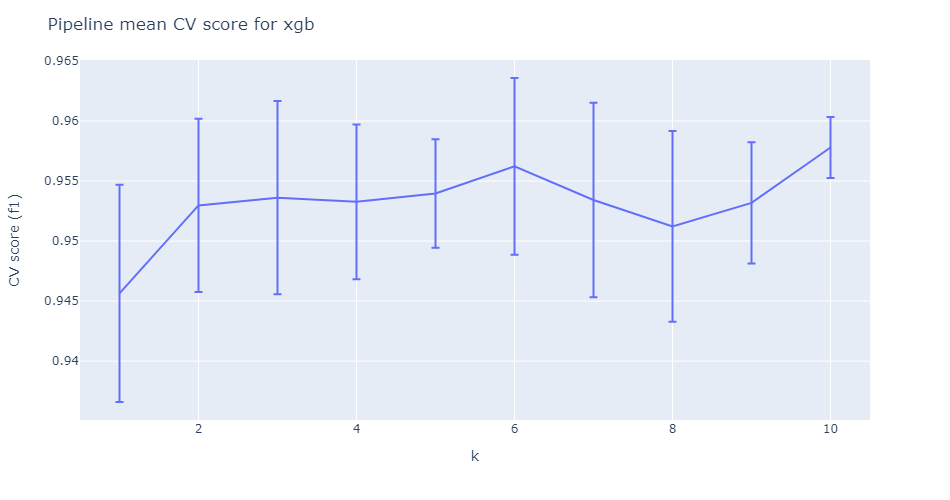

In [167]:
score_mean = xgb_mi_cv1.cv_results_['mean_test_score']
score_std = xgb_mi_cv1.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for xgb',
                  yaxis_title='CV score (f1)', width=950, height=500)

fig.show('png')

In [291]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif, k=2)), ('xgb', xgb.XGBClassifier(**best_params1))]
pipeline =  Pipeline(steps)
pipeline.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oh',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['creation_source']),
                                                 ('target',
                                                  TargetEncoder(random_state=0),
                                                  ['org_id',
                                                   'invited_by_user_id'])])),
                ('selectkbest',
                 SelectKBest(k=2,
                             score_func=<function mutual_info_classif at 0x000001EBC88F4680>)),
                ('xgb',
                 XGBClassifier(...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.9827155300337743, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=15,
                               max_leaves=None,
                               min_child_weight=0.6843152593815784, missing=nan,
                               monotone_constraints=None, n_estimators=316,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [292]:
idx = pipeline.named_steps.selectkbest.get_support()
idx

array([False, False, False, False, False, False, False, False,  True,
        True])

In [293]:
importances = pipeline.named_steps.xgb.feature_importances_
importance_xgb_mi = pd.DataFrame({'feature': pipeline.named_steps.prep.get_feature_names_out()[idx], 
                              'importance': importances})
importance_xgb_mi.feature = importance_xgb_mi.feature.str.replace('.*__','', regex=True)
top_xgb_mi = importance_xgb_mi.sort_values('importance', ascending=False)
top_xgb_mi

feature  importance
0   length    0.609039
1  visited    0.390961

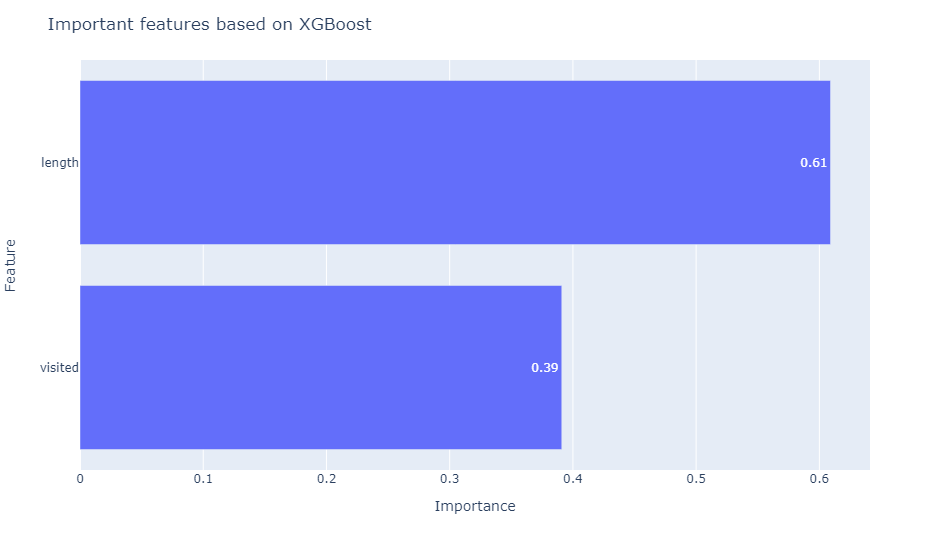

In [294]:
fig = px.bar(x=top_xgb_mi.importance[::-1], y=top_xgb_mi.feature[::-1], text_auto='.2', width=950, height=550)
fig.update_layout(template = 'plotly', title='Important features based on XGBoost',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('png')

In [295]:
y_pred = pipeline.predict(X)
y_prob = pipeline.predict_proba(X)

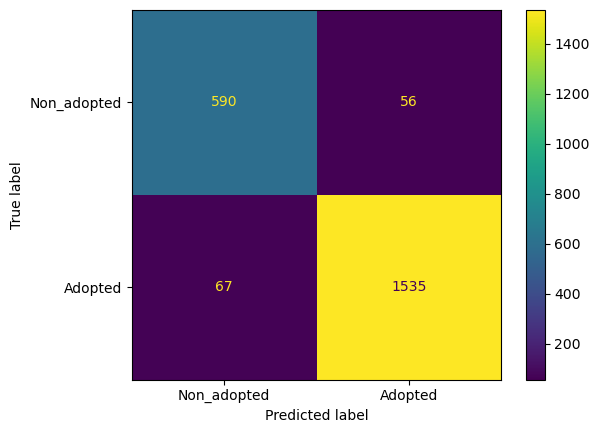

In [296]:
cm = confusion_matrix(y, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non_adopted', 'Adopted'])
cmd.plot()
plt.show()

In [297]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       646
           1       0.96      0.96      0.96      1602

    accuracy                           0.95      2248
   macro avg       0.93      0.94      0.93      2248
weighted avg       0.95      0.95      0.95      2248



In [299]:
(590+1535)/df.shape[0]

0.9452846975088968